# FomulaBEAT

ポーランド記法から逆ポーランド記法へ変換するタスク

4-1-5からの変更点
- データを空白を削除したもの、さらに深さは0-4（03-5）で層ごとのサイズを同数に
- 次元を16次元にする
- lossやAccuracyなどの可視化



In [1]:
version = '04-2-1'
model_dir = './model/' + version
data_path = 'data/eq03-5.txt'
test_data_path = 'data/eq03-5-test.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F
from torch import Tensor

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['9', '++04+93', '++9+05+0+68'] ['9', '04+93++', '905++068+++']


辞書データの作成

In [7]:
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '<start>': 11, '<end>': 12, '<pad>': 13, '<unk>': 14}


In [9]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[11, 10, 14, 10, 14, 1, 14, 5, 14, 10, 14, 8, 14, 5, 12]

In [10]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([11, 10,  8,  7, 12])
Output: tensor([11,  8,  7, 10, 12])
元に戻した文章
Input: +87
Output: 87+


In [11]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [12]:
len(train_data)

800000

Transoformerの設定

In [13]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [14]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        return tgt


In [15]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs, self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [16]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [17]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [18]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [19]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 16
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [20]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(15, 16, padding_idx=13)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)


In [21]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


13 層

層名: token_embedding.embedding.weight
形状: torch.Size([15, 16])
値: Parameter containing:
tensor([[ 0.1393,  0.0983,  0.4047,  0.3025, -0.3246, -0.0927, -0.3600, -0.0904, -0.1931, -0.1615,
         -0.1159,  0.3974,  0.4364,  0.1379,  0.4339, -0.4101],
        [ 0.2804, -0.3106,  0.2438,  0.3626,  0.2208,  0.1243,  0.2359,  0.3146, -0.2701, -0.2713,
          0.2329,  0.1318, -0.3473,  0.3311, -0.1126,  0.0317],
        [-0.2408, -0.3715, -0.3389, -0.1188, -0.0761, -0.2826,  0.4378,  0.4350, -0.0094, -0.0215,
         -0.0503,  0.3240,  0.3192, -0.2163, -0.3817,  0.3344],
        [-0.0602,  0.1494,  0.0816,  0.2598, -0.3987,  0.1165, -0.2379, -0.2142, -0.3072, -0.2218,
          0.1172, -0.4375, -0.4306,  0.4259, -0.0244,  0.3572],
        [ 0.3194, -0.4038,  0.1776,  0.4078, -0.3162,  0.2835, -0.1845,  0.4396,  0.0852, -0.3178,
         -0.4260,  0.3774,  0.1159, -0.3510, -0.0880, -0.1633],
        [-0.1107,  0.1741,  0.0380,  0.1234, -0.1937,  0.1707,  0.0590,  0.1243, -0.3682,  0

## 学習実行

In [22]:
epoch = 20
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

# 可視化用に保存
train_losses = []
valid_losses = []

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )

    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    print('[{}/{}] train loss: {:.4f}, valid loss: {:.4f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    counter += 1
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    

  0%|          | 0/782 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 782/782 [00:12<00:00, 63.82it/s]


[1/20] train loss: 1.53, valid loss: 1.04  [12s] counter: 0 **


100%|██████████| 782/782 [00:12<00:00, 65.11it/s]


[2/20] train loss: 0.85, valid loss: 0.70  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.24it/s]


[3/20] train loss: 0.54, valid loss: 0.46  [12s] counter: 0 **


100%|██████████| 782/782 [00:12<00:00, 65.12it/s]


[4/20] train loss: 0.37, valid loss: 0.30  [12s] counter: 0 **


100%|██████████| 782/782 [00:12<00:00, 64.74it/s]


[5/20] train loss: 0.23, valid loss: 0.16  [12s] counter: 0 **


100%|██████████| 782/782 [00:12<00:00, 62.39it/s]


[6/20] train loss: 0.13, valid loss: 0.11  [13s] counter: 0 **


100%|██████████| 782/782 [00:12<00:00, 62.37it/s]


[7/20] train loss: 0.10, valid loss: 0.10  [13s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.46it/s]


[8/20] train loss: 0.09, valid loss: 0.09  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.47it/s]


[9/20] train loss: 0.08, valid loss: 0.08  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.40it/s]


[10/20] train loss: 0.08, valid loss: 0.07  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.56it/s]


[11/20] train loss: 0.07, valid loss: 0.06  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.49it/s]


[12/20] train loss: 0.06, valid loss: 0.06  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.46it/s]


[13/20] train loss: 0.06, valid loss: 0.06  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.57it/s]


[14/20] train loss: 0.06, valid loss: 0.06  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.51it/s]


[15/20] train loss: 0.05, valid loss: 0.05  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.41it/s]


[16/20] train loss: 0.05, valid loss: 0.05  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.51it/s]


[17/20] train loss: 0.06, valid loss: 0.05  [12s] counter: 0 **


100%|██████████| 782/782 [00:11<00:00, 65.54it/s]


[18/20] train loss: 0.05, valid loss: 0.05  [12s] counter: 0 


100%|██████████| 782/782 [00:12<00:00, 64.93it/s]


[19/20] train loss: 0.05, valid loss: 0.05  [12s] counter: 1 **


100%|██████████| 782/782 [00:11<00:00, 65.42it/s]


[20/20] train loss: 0.05, valid loss: 0.05  [12s] counter: 0 **


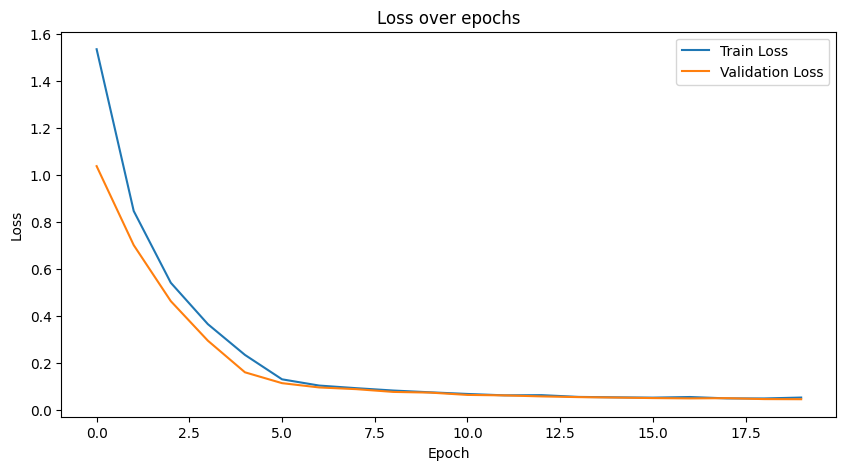

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

学習したモデルの保存

In [24]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [25]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [26]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.compute_output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [27]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

# 翻訳を実行
translation = translate(
    model=loaded_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: ++15+85
Output: 15+85++


In [28]:
# 様々な入力を試してみる

text_list = {
'5':'5',
'+62':'62+',
'+2+7+56':'2756+++',
'+++457+00':'45+7+00++',
# '+++91+96++820':'91+96++82+0++',
'+++43+52++99+12':'43+52++99+12+++',
'+1++48+17':'148+17+++',
'+0+82':'082++',
}
# text_list += { '+ 2 7':'2 7 -', '+ 9 7' : '9 7 -', '+ + 2 7 4' : '2 7 - 4 +', '+ + 6 9 - 7 3' : '6 9 - 7 3 - -', '+ + + + + + + 4 6 3 7 + 6 7 1 9 + + 3 6 2' : '4 6 + 3 + 7 + 6 7 + + 1 + 9 - 3 6 + 2 + + '}

for text, tgt in text_list.items():
    translation = translate(
        model=loaded_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input  : {text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt}")
    print('---')


Input  : 5
Output : 5
Correct: 5
---
Input  : +62
Output : 62+
Correct: 62+
---
Input  : +2+7+56
Output : 275+6++
Correct: 2756+++
---
Input  : +++457+00
Output : 45+7+0+++
Correct: 45+7+00++
---
Input  : +++43+52++99+12
Output : 43+52++99+12+++
Correct: 43+52++99+12+++
---
Input  : +1++48+17
Output : 148++17++
Correct: 148+17+++
---
Input  : +0+82
Output : 082++
Correct: 082++
---


In [29]:
# テスト用ファイルの読み込み関数
def read_test_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    test_data = []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        test_data.append((src, tgt))
    return test_data

# 正答率を計算する関数
def calculate_accuracy(model, test_data, vocab_src, vocab_tgt, seq_len_tgt, START_IDX, END_IDX):
    correct = 0
    total = len(test_data)
    mistakes = []

    for src_text, tgt_text in test_data:
        # モデルを使って翻訳を実行
        translation = translate(
            model=model, text=src_text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
            seq_len_tgt=seq_len_tgt,
            START_IDX=START_IDX, END_IDX=END_IDX
        )

        # 正答のチェック
        if translation == tgt_text:
            correct += 1
        else:
            # 間違えたものを保存
            mistakes.append((src_text, translation, tgt_text))

    accuracy = correct / total * 100
    return accuracy, mistakes


# テストデータの読み込み
test_data = read_test_file(test_data_path)

# 正答率の計算（間違いの詳細も取得）
accuracy, mistakes = calculate_accuracy(
    model=loaded_model, test_data=test_data,
    vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

# 正答率の表示
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Mistakes: {len(mistakes)} out of {len(test_data)}")

# 間違えたケースの一部（10件まで）を表示
print("\nExamples of mistakes:")
for i, (src_text, translation, tgt_text) in enumerate(mistakes[:10]):
    print(f"Input  : {src_text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt_text}")
    print('---')


Test Accuracy: 94.40%
Mistakes: 112 out of 2000

Examples of mistakes:
Input  : +0++750
Output : 077+0++
Correct: 075+0++
---
Input  : ++4+43+5+24
Output : 443+525++4+
Correct: 443++524+++
---
Input  : +++7442
Output : 74+42++
Correct: 74+4+2+
---
Input  : ++22++65+63
Output : 22+65++63++
Correct: 22+65+63+++
---
Input  : +++969++14+32
Output : 99+9+14+32+++
Correct: 96+9+14+32+++
---
Input  : +4++27+87
Output : 422++87++
Correct: 427+87+++
---
Input  : ++8+84+1+71
Output : 884+117++1+
Correct: 884++171+++
---
Input  : +++792++141
Output : 79+2+141+++
Correct: 79+2+14+1++
---
Input  : +3+5+05
Output : 350+5++
Correct: 3505+++
---
Input  : ++2+62++202
Output : 262++202+++
Correct: 262++20+2++
---


## モデルの動作を分析

In [30]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(15, 16, padding_idx=13)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
  )
)

In [31]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding.embedding.weight torch.Size([15, 16])
decoder_layer.self_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.self_attn.in_proj_bias torch.Size([48])
decoder_layer.self_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.self_attn.out_proj.bias torch.Size([16])
decoder_layer.multihead_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.multihead_attn.in_proj_bias torch.Size([48])
decoder_layer.multihead_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.multihead_attn.out_proj.bias torch.Size([16])
decoder_layer.norm1.weight torch.Size([16])
decoder_layer.norm1.bias torch.Size([16])
decoder_layer.norm2.weight torch.Size([16])
decoder_layer.norm2.bias torch.Size([16])


In [32]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_weight = params['token_embedding.embedding.weight'].data


# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data


In [33]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Attentionを確認

In [37]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: ++15+85
memory: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 1.2438, -0.6305,  0.6733, -0.1499,  0.0632, -1.0485, -0.8788,  1.9697, -1.9643,  2.9094,
           1.6526,  1.9463, -0.0815, -0.0498, -1.0288, -0.8098]],

        [[ 1.3117, -1.5870,  0.9535, -0.2937,  0.1620, -1.0634, -0.8472,  1.9682, -1.9543,  2.9092,
           1.6557,  1.9462, -0.0805, -0.0498, -1.0284, -0.8098]],

        [[-0.1308, -1.6610,  1.7921,  1.3588,  1.3633,  1.3513,  1.1507, -0.2658,  1.4866, -1.6200,
          -0.4106,  3.7773, -1.0053,  2.5418, -1.7825,  0.3241]],

        [[-1.6037, -2.0266,  1.6321, -0.8564, -0.5159,  2.5766,  2.5450,  1.0492, -0.2088,  0.3382,
          -2.8308, -0.0130, -0.9135,  2.0900, -2.9896, -0.6002]],

        [[-0.5566, -0.8872,  1.3623, -1.1106,  0.4427, -1.1659, -0.7529,  1.9577, -1.9243,  2.9082,
           1.6652,  1.9461, -0.0775, -0.049

text: ++15+85
memory: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 1.2438, -0.6305,  0.6733, -0.1499,  0.0632, -1.0485, -0.8788,  1.9697, -1.9643,  2.9094,
           1.6526,  1.9463, -0.0815, -0.0498, -1.0288, -0.8098]],

        [[ 1.3117, -1.5870,  0.9535, -0.2937,  0.1620, -1.0634, -0.8472,  1.9682, -1.9543,  2.9092,
           1.6557,  1.9462, -0.0805, -0.0498, -1.0284, -0.8098]],

        [[-0.1308, -1.6610,  1.7921,  1.3588,  1.3633,  1.3513,  1.1507, -0.2658,  1.4866, -1.6200,
          -0.4106,  3.7773, -1.0053,  2.5418, -1.7825,  0.3241]],

        [[-1.6037, -2.0266,  1.6321, -0.8564, -0.5159,  2.5766,  2.5450,  1.0492, -0.2088,  0.3382,
          -2.8308, -0.0130, -0.9135,  2.0900, -2.9896, -0.6002]],

        [[-0.5566, -0.8872,  1.3623, -1.1106,  0.4427, -1.1659, -0.7529,  1.9577, -1.9243,  2.9082,
           1.6652,  1.9461, -0.0775, -0.049

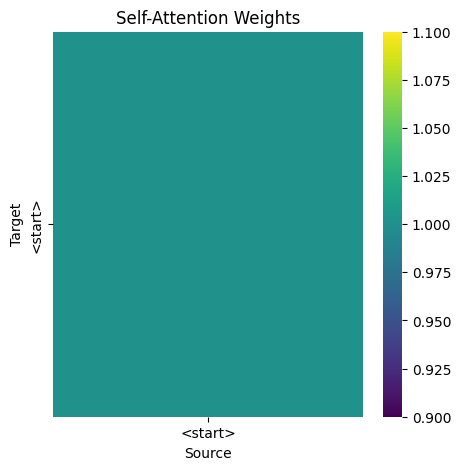

QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 16])
multi_attention: 
[[2.1075648e-04 1.2241560e-04 1.3823669e-03 9.8082697e-01 1.7427538e-02
  1.3221957e-07 1.2798586e-05 1.7047598e-05 1.0031899e-09]]
After Attention: tensor([[[ 0.7238, -0.1362, -0.1172, -0.1552,  2.6647,  4.0477,  0.6511, -4.9560,  0.0885, -6.8749,
           2.6044, 10.2784, -3.0005,  0.3599, -1.8107, -1.7910]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


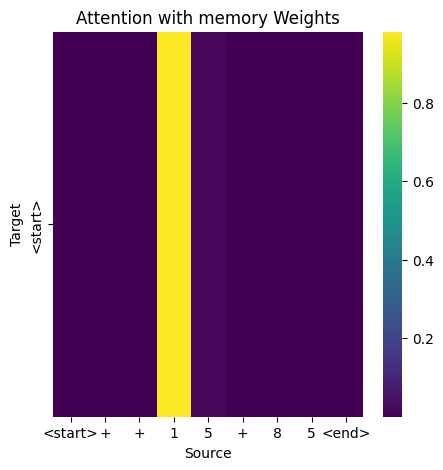

output.shape: torch.Size([1, 15])
output: tensor([[  1.6306,  16.1643,  -0.7687,  -7.2859,   2.1542,   0.8468,   1.3389,   0.9876, -10.2412,
          -5.8439,  -1.8741,   1.5282,  -2.9181,  -3.7561,  -3.7588]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 1
ys: tensor([[11],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]]], device='cuda:0')
now tgt: 1
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196

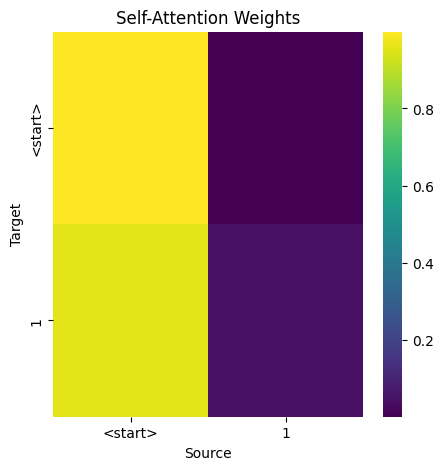

QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 16])
multi_attention: 
[[2.0978518e-04 1.2386158e-04 1.3994417e-03 9.8089361e-01 1.7343398e-02
  1.3247328e-07 1.2771971e-05 1.7077948e-05 9.8894626e-10]
 [1.5063890e-02 7.5408190e-02 8.7806024e-02 8.5483529e-02 3.0717653e-01
  3.4464562e-01 7.6084867e-02 8.3310865e-03 2.8883869e-07]]
After Attention: tensor([[[ 0.7226, -0.1368, -0.1174, -0.1567,  2.6650,  4.0471,  0.6507, -4.9565,  0.0890, -6.8747,
           2.6064, 10.2787, -2.9987,  0.3603, -1.8107, -1.7910]],

        [[ 1.6637, -1.4218,  1.4624, -3.9969, -6.8219,  8.9976,  6.3964,  0.4784, -4.4423,  0.2216,
          -2.2038,  1.8306, -1.0234,  1.0104, -1.2483, -2.3386]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)


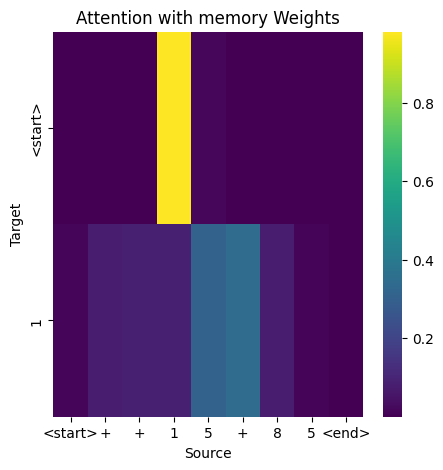

output.shape: torch.Size([1, 15])
output: tensor([[-10.1678,   1.6543,  -5.1334,  -2.5176,  -1.2350,  14.4051,  -0.0382,  -1.7389,   0.5393,
         -11.9568,  -1.1005,   1.7356,   1.3199,  -4.8138,  -3.4137]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 2
ys: tensor([[11],
        [ 1],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]]], device='cuda:0')
now tgt: 15
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -

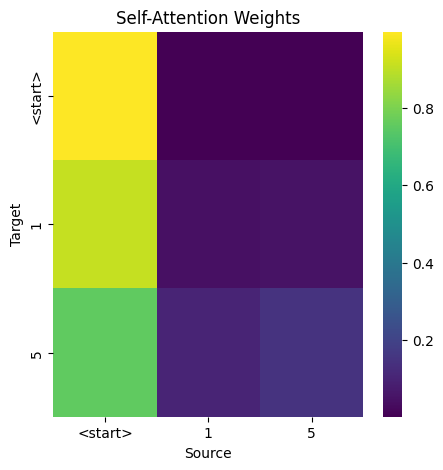

QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 16])
multi_attention: 
[[2.07722725e-04 1.25621984e-04 1.42166030e-03 9.81056511e-01
  1.71586145e-02 1.31878707e-07 1.26632667e-05 1.70476014e-05
  9.68180980e-10]
 [1.03949765e-02 1.09338537e-01 1.19031817e-01 5.57039976e-02
  1.89225599e-01 4.40593570e-01 6.76406473e-02 8.07072781e-03
  1.56256462e-07]
 [3.35275522e-03 1.55905128e-01 9.45094898e-02 1.12814037e-02
  1.53755816e-02 6.54116690e-01 5.72173521e-02 8.24154634e-03
  5.56054980e-09]]
After Attention: tensor([[[ 0.7210, -0.1375, -0.1178, -0.1585,  2.6660,  4.0458,  0.6498, -4.9571,  0.0895, -6.8748,
           2.6095, 10.2792, -2.9958,  0.3607, -1.8107, -1.7907]],

        [[ 1.9148, -1.3693,  1.8696, -4.0737, -7.0355,  8.2502,  6.6577,  1.1669, -5.0318,  0.2003,
          -1.8660,  2.0090, -0.7736,  0.6278, -1.3440, -2.6102]],

        [[ 2.9857, -3.3102,  3.

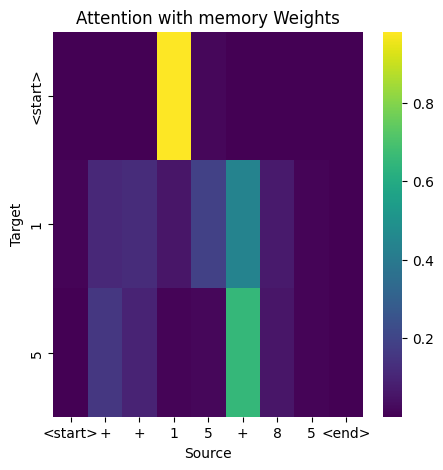

output.shape: torch.Size([1, 15])
output: tensor([[ -7.2912, -10.0525,  -5.1980,  -6.7646,  -7.5076,   3.7686,  -3.0530,  -8.9098,   7.1112,
         -14.1574,  14.7239,  -1.7201,   3.8108,  -6.2149,  -3.9472]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 3
ys: tensor([[11],
        [ 1],
        [ 5],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0.8156,  1.9657, -1.9443,  2.9090,
        

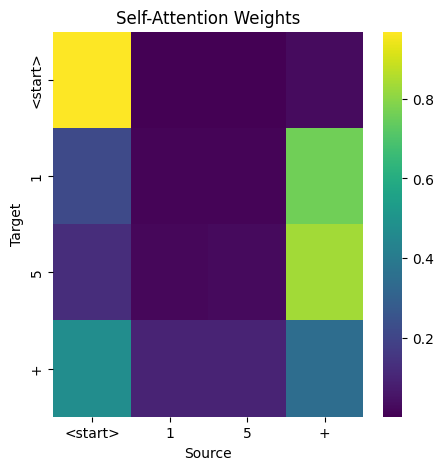

QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 16])
multi_attention: 
[[1.65574093e-04 7.48233579e-05 9.30841488e-04 9.84049678e-01
  1.47585208e-02 6.08541342e-08 8.45367686e-06 1.21001431e-05
  8.54087745e-10]
 [7.96101093e-02 6.28868051e-08 1.72477129e-07 2.77018905e-01
  5.84714353e-01 1.26410285e-07 3.96697856e-02 1.79725569e-02
  1.01397291e-03]
 [1.67884737e-01 1.46626293e-08 2.48719978e-08 3.63846779e-01
  3.36753249e-01 7.81649376e-08 1.00074485e-01 3.05800624e-02
  8.60510103e-04]
 [9.82850208e-04 3.06377005e-05 2.55099394e-06 7.49850660e-05
  1.15786248e-03 1.59548398e-03 8.48979473e-01 1.47176236e-01
  8.07052613e-13]]
After Attention: tensor([[[ 0.7323, -0.1079, -0.1224, -0.1230,  2.6772,  4.0141,  0.6293, -4.9534,  0.0839, -6.8857,
           2.6074, 10.2871, -3.0019,  0.3419, -1.8095, -1.7887]],

        [[ 2.8808, -0.6277,  0.2643, -3.5677, -5.4094,  

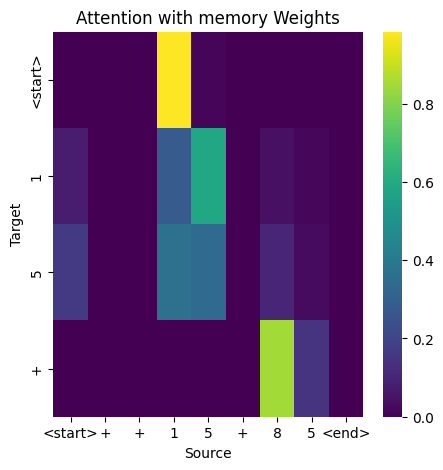

output.shape: torch.Size([1, 15])
output: tensor([[ 1.5272e-02, -9.7315e+00,  2.1357e+00, -3.4209e+00, -4.7462e+00,  3.5493e+00,  1.2454e+00,
         -5.5559e+00,  1.5947e+01, -7.9248e+00,  1.0570e+01, -4.2099e+00, -5.9324e+00, -5.5276e+00,
         -4.3445e+00]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 8

------------------

iter: 4
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0

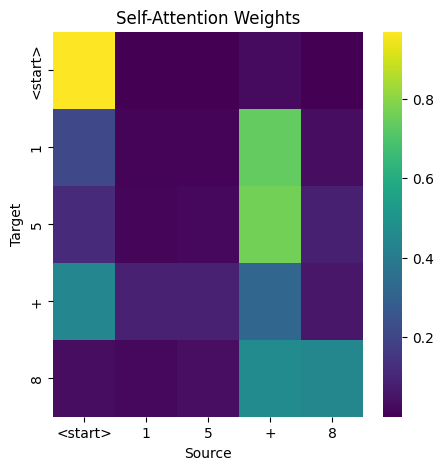

QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 16])
multi_attention: 
[[1.65209523e-04 7.51672123e-05 9.35668242e-04 9.84085083e-01
  1.47183454e-02 6.08372872e-08 8.42861482e-06 1.20892628e-05
  8.51157089e-10]
 [8.82618055e-02 1.06013935e-07 2.82403647e-07 2.60089517e-01
  5.77513337e-01 2.09752116e-07 4.88989092e-02 2.36252286e-02
  1.61061366e-03]
 [2.38742068e-01 6.32320010e-08 8.00907713e-08 2.50858039e-01
  2.03733563e-01 4.41974123e-07 2.28582203e-01 7.55859464e-02
  2.49754009e-03]
 [2.88283918e-03 1.41432672e-03 2.32572551e-04 4.52051812e-04
  1.27667328e-03 4.79211332e-03 4.82560992e-01 5.06388485e-01
  4.13497257e-11]
 [4.29538125e-03 9.85091105e-02 6.10010512e-02 8.41330551e-03
  1.30339386e-03 9.06325504e-03 3.27839404e-02 7.84630120e-01
  3.41728764e-07]]
After Attention: tensor([[[ 7.3192e-01, -1.0795e-01, -1.2248e-01, -1.2340e-01,  2.6775e+00,  4.013

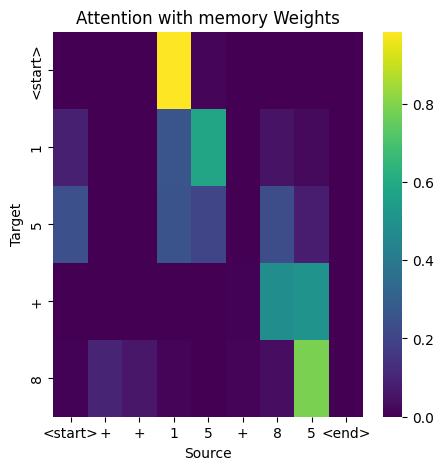

output.shape: torch.Size([1, 15])
output: tensor([[-11.0163,  -2.4999,  -5.2057,  -2.0873,  -3.8904,  11.3098,  -2.5003,  -1.1206,  -0.1997,
         -10.5451,   8.3833,  -3.9191, -13.7734,  -7.7351,  -7.0831]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 5
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0.8156,  1.9657,

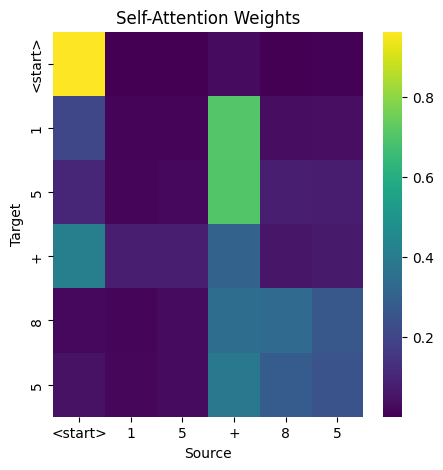

QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 16])
multi_attention: 
[[1.61590899e-04 8.00179405e-05 1.00169878e-03 9.84487355e-01
  1.42491059e-02 6.12841902e-08 8.20134210e-06 1.20114119e-05
  8.13643874e-10]
 [1.02529556e-01 2.18359943e-07 5.52619554e-07 2.32412741e-01
  5.60545981e-01 4.49070882e-07 6.85154200e-02 3.32606435e-02
  2.73448415e-03]
 [2.20521227e-01 5.43783131e-07 4.41141168e-07 7.97582343e-02
  5.32494895e-02 5.47162654e-06 4.87814814e-01 1.55563965e-01
  3.08583467e-03]
 [5.31983050e-03 7.81310350e-03 2.07344373e-03 1.38577900e-03
  1.46116805e-03 6.27599098e-03 3.03855062e-01 6.71815634e-01
  4.12448797e-10]
 [4.94598178e-03 2.38157257e-01 1.53427258e-01 8.22638627e-03
  1.33350468e-03 2.06174664e-02 3.95553410e-02 5.33736765e-01
  9.33553608e-08]
 [2.71015824e-03 4.36345607e-01 3.94850284e-01 4.08453541e-03
  3.46510729e-04 2.16429606e-02 1.694

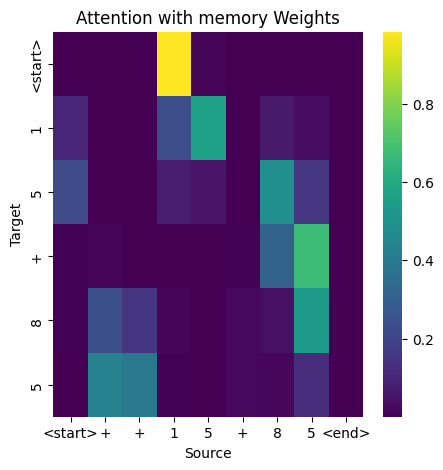

output.shape: torch.Size([1, 15])
output: tensor([[-10.1618,  -6.3455,  -6.9950,  -6.2857,  -7.2746,   1.1007,  -6.3389,  -5.4862,  -4.1070,
         -10.9314,  17.6399,  -8.4253,  -5.2060,  -7.7809,  -6.4111]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 6
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0

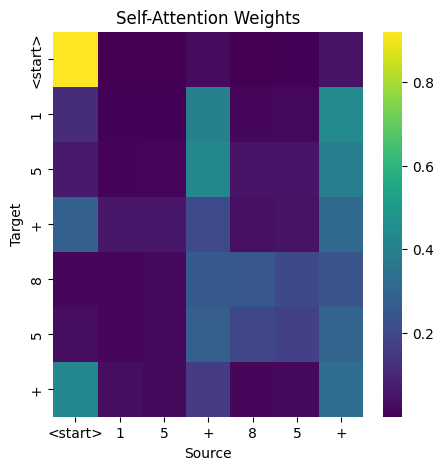

QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 16])
multi_attention: 
[[1.16501818e-04 3.38681566e-05 4.86541918e-04 9.87727880e-01
  1.16233425e-02 1.88271549e-08 4.59810099e-06 7.17759485e-06
  6.75975553e-10]
 [1.24237671e-01 3.14380593e-08 6.91848783e-08 1.96939901e-01
  5.44184923e-01 1.35297824e-07 9.07841474e-02 4.23942320e-02
  1.45891996e-03]
 [2.41264284e-01 2.91189330e-08 3.11012904e-08 1.38457179e-01
  1.90696672e-01 5.37676556e-07 3.39931846e-01 8.83753151e-02
  1.27406127e-03]
 [6.33459259e-03 8.31721358e-11 1.19933542e-11 5.23749404e-05
  4.52695589e-04 5.52980151e-09 4.48783338e-01 5.44377029e-01
  6.61227428e-09]
 [4.63654660e-03 6.52024522e-02 3.22610736e-02 4.79950756e-03
  1.08375284e-03 1.75783783e-02 5.59339076e-02 8.18504095e-01
  2.93580115e-07]
 [1.09995510e-02 2.44987756e-01 2.07963333e-01 8.02306272e-03
  7.71782361e-04 4.92433645e-02 8.797

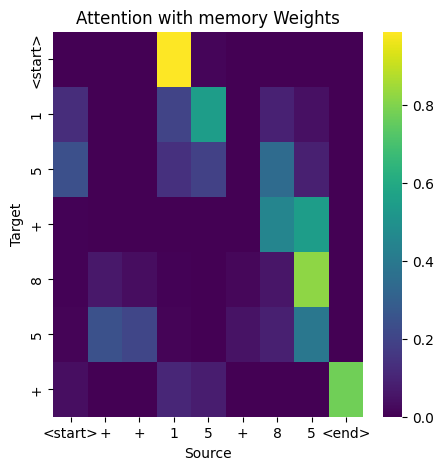

output.shape: torch.Size([1, 15])
output: tensor([[  0.9109,   2.0788,   0.7052,   0.7225,   0.8464,   1.7429,   1.1110,   1.4484,   0.4453,
           0.2056,  11.5483,  -5.0019, -35.3541, -10.6730, -10.8949]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 7
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5],
        [10],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.258

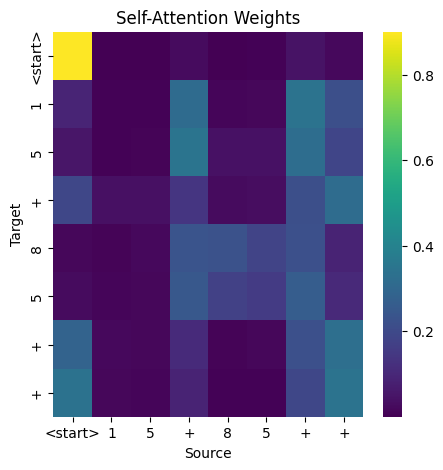

QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 16])
multi_attention: 
[[1.00082107e-04 2.08978163e-05 3.18866660e-04 9.88843441e-01
  1.07074976e-02 1.02438769e-08 3.55859174e-06 5.66591279e-06
  6.11296402e-10]
 [1.08079299e-01 1.27229907e-08 2.74829457e-08 2.09511131e-01
  5.58411777e-01 5.85870730e-08 8.52092132e-02 3.81401516e-02
  6.48346147e-04]
 [2.04632908e-01 1.06322284e-08 1.25016664e-08 1.79691672e-01
  2.71623552e-01 1.84127742e-07 2.74680227e-01 6.88167140e-02
  5.54698112e-04]
 [1.19078226e-01 5.66288370e-11 4.27654231e-11 3.97188403e-02
  1.15737423e-01 6.89821311e-10 3.83671314e-01 3.41789216e-01
  4.96950634e-06]
 [4.01085196e-03 1.85271371e-02 8.06549005e-03 3.66949104e-03
  1.00483920e-03 9.41938348e-03 6.21297807e-02 8.93172503e-01
  4.15777833e-07]
 [2.43411120e-02 5.51922172e-02 4.78255153e-02 1.63313393e-02
  1.86948187e-03 2.50039045e-02 2.091

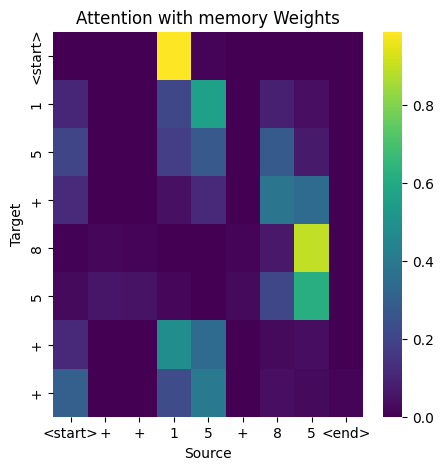

output.shape: torch.Size([1, 15])
output: tensor([[-12.5693,  -5.6521, -10.4536,  -8.3322,  -7.5729,   0.8850, -11.6564,  -9.5023,  -8.5385,
         -18.3990,  10.0677,  -0.7405,  27.2239,  -5.1709,  -1.3726]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 12

------------------

Input: ++15+85
Decoded sequence: 15+85++


In [38]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    print(f"After Attention: {tgt}")
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Attention with memory Weights")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

### MDSを利用

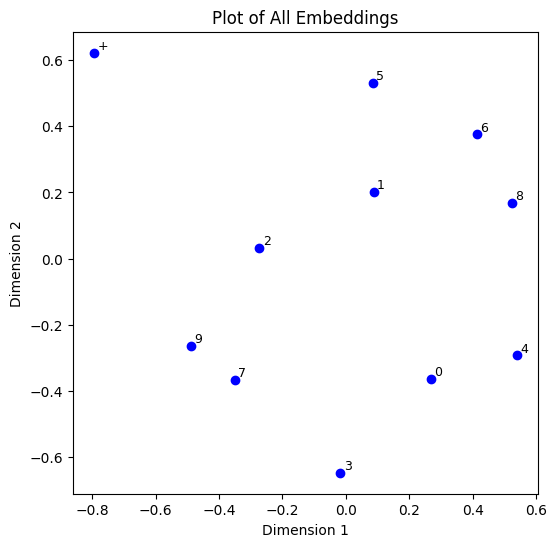

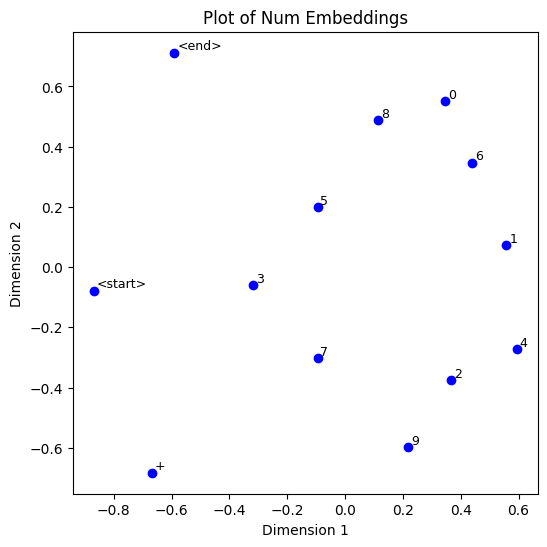

In [174]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt

# コサイン類似度に基づいてMDSで2次元に射影する関数
def apply_mds(embedding_weight, n_components=2):
    # コサイン類似度行列の計算
    cosine_sim = cosine_similarity(embedding_weight.cpu().detach().numpy())
    
    # 類似度を距離として扱うために、1 - コサイン類似度に変換
    distance_matrix = 1 - cosine_sim
    
    # MDSを適用して2次元に射影
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42)
    embedding_2d_mds = mds.fit_transform(distance_matrix)
    
    return embedding_2d_mds

# 逆辞書を作成
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

# 2次元に射影された埋め込みベクトルのプロット
def plot_embedding_tgt_2d(embedded_weight, ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))
    embedded_weight = embedded_weight.cpu().detach()

    if tgt_embed is not None:
        # TensorのままMDSを適用する
        tgt_embed = tgt_embed.cpu().detach()
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=1)
        
        # embedded_weightとtgt_embedを結合しMDSを適用
        embed = np.vstack((embedded_weight.numpy(), tgt_embed.numpy()))
        embedded_weight_2d = apply_mds(torch.tensor(embed), n_components=2)
        tgt_embed_2d = embedded_weight_2d[-tgt_embed.shape[0]:]  # 最後のベクトルがターゲット埋め込み
        embedded_weight_2d = embedded_weight_2d[:-tgt_embed.shape[0]]  # 残りはもともとの埋め込み

        # ターゲット埋め込みベクトルをプロット
        for i, (x, y) in enumerate(tgt_embed_2d):
            if tgt_embed.shape[0] == 1:
                label = "Taget"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='red', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, label, fontsize=9)
    else:
        # コサイン類似度に基づくMDSを適用してプロット
        embedded_weight_2d = apply_mds(embedded_weight, n_components=2)

    # MDSで圧縮された埋め込みをプロット
    for i, (x, y) in enumerate(embedded_weight_2d):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


# プロットの実行
plot_embedding_tgt_2d(embedding_weight[:11, :], title="All Embeddings")
plot_embedding_tgt_2d(embedding_weight[:13, :], title="Num Embeddings")


text: ++15+85
memory: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 1.2438, -0.6305,  0.6733, -0.1499,  0.0632, -1.0485, -0.8788,  1.9697, -1.9643,  2.9094,
           1.6526,  1.9463, -0.0815, -0.0498, -1.0288, -0.8098]],

        [[ 1.3117, -1.5870,  0.9535, -0.2937,  0.1620, -1.0634, -0.8472,  1.9682, -1.9543,  2.9092,
           1.6557,  1.9462, -0.0805, -0.0498, -1.0284, -0.8098]],

        [[-0.1308, -1.6610,  1.7921,  1.3588,  1.3633,  1.3513,  1.1507, -0.2658,  1.4866, -1.6200,
          -0.4106,  3.7773, -1.0053,  2.5418, -1.7825,  0.3241]],

        [[-1.6037, -2.0266,  1.6321, -0.8564, -0.5159,  2.5766,  2.5450,  1.0492, -0.2088,  0.3382,
          -2.8308, -0.0130, -0.9135,  2.0900, -2.9896, -0.6002]],

        [[-0.5566, -0.8872,  1.3623, -1.1106,  0.4427, -1.1659, -0.7529,  1.9577, -1.9243,  2.9082,
           1.6652,  1.9461, -0.0775, -0.049

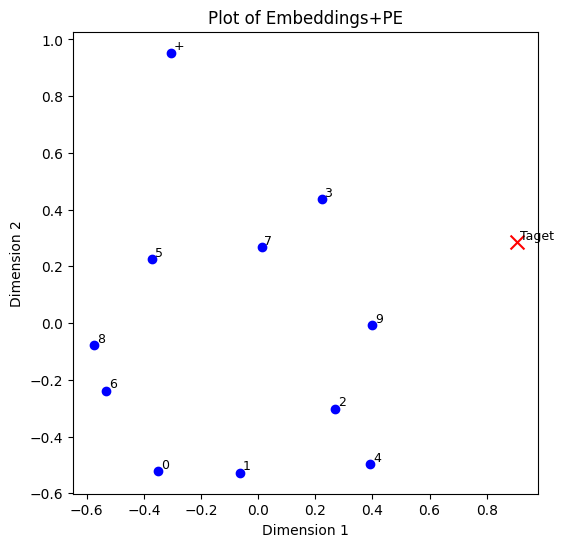

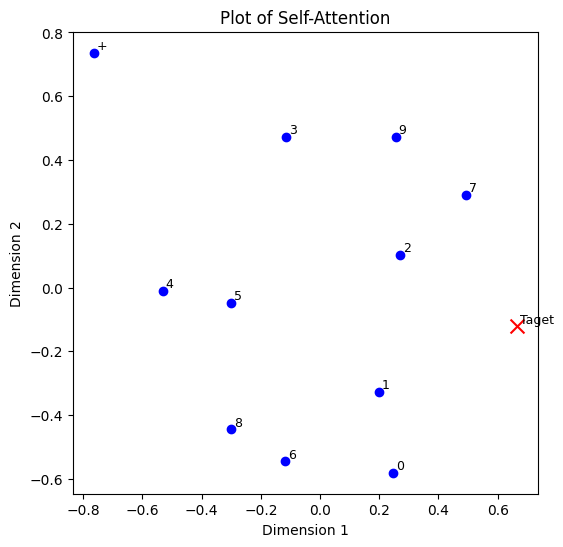

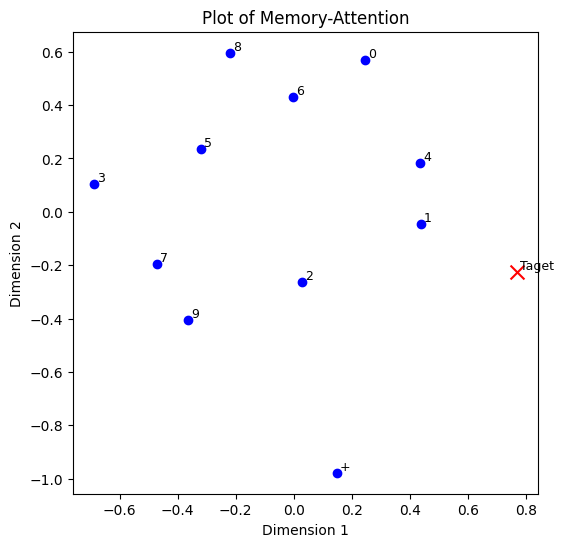

output.shape: torch.Size([1, 15])
output: tensor([[  1.6306,  16.1643,  -0.7687,  -7.2859,   2.1542,   0.8468,   1.3389,   0.9876, -10.2412,
          -5.8439,  -1.8741,   1.5282,  -2.9181,  -3.7561,  -3.7588]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 1
ys: tensor([[11],
        [ 1]], device='cuda:0')


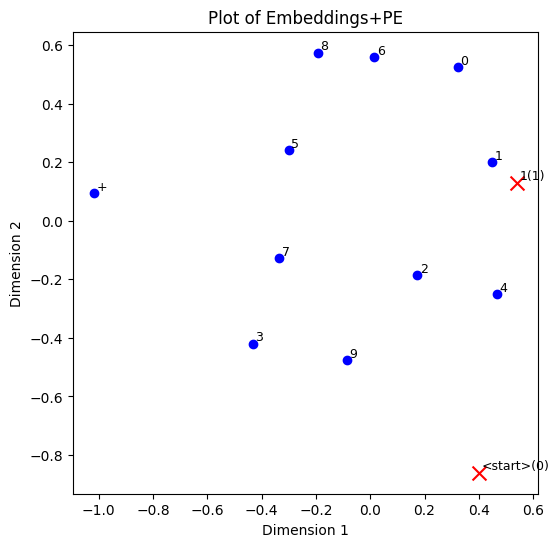

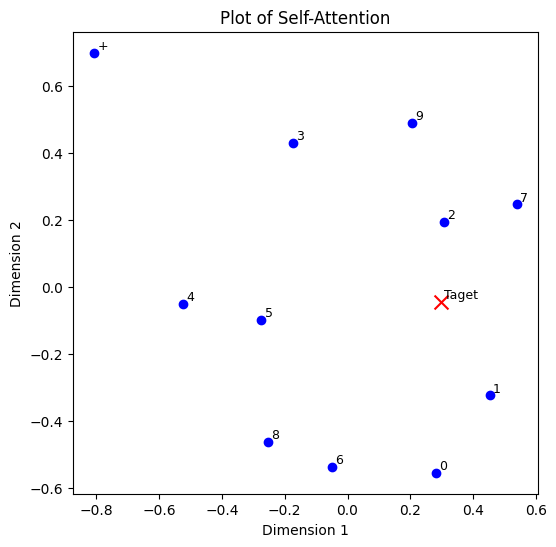

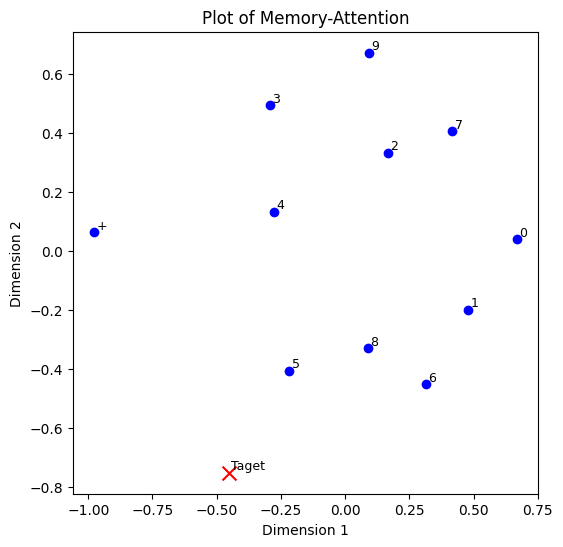

output.shape: torch.Size([1, 15])
output: tensor([[-10.1678,   1.6543,  -5.1334,  -2.5176,  -1.2350,  14.4051,  -0.0382,  -1.7389,   0.5393,
         -11.9568,  -1.1005,   1.7356,   1.3199,  -4.8138,  -3.4137]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 2
ys: tensor([[11],
        [ 1],
        [ 5]], device='cuda:0')


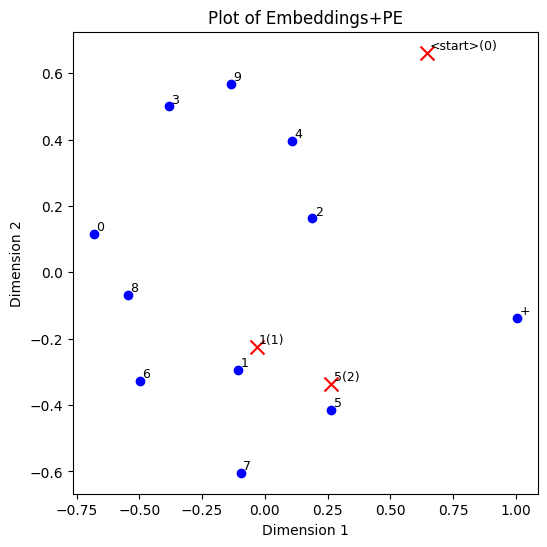

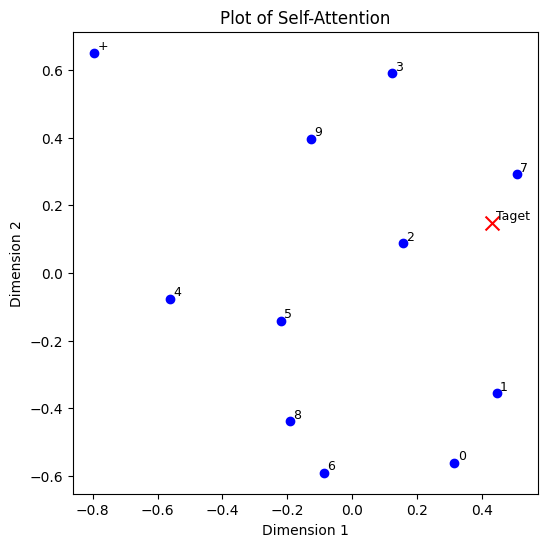

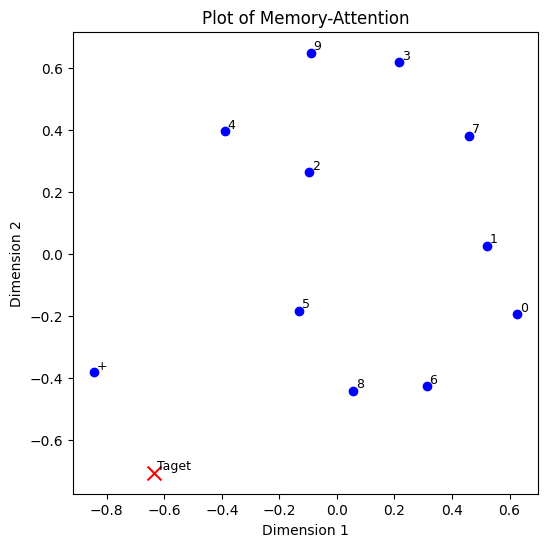

output.shape: torch.Size([1, 15])
output: tensor([[ -7.2912, -10.0525,  -5.1980,  -6.7646,  -7.5076,   3.7686,  -3.0530,  -8.9098,   7.1112,
         -14.1574,  14.7239,  -1.7201,   3.8108,  -6.2149,  -3.9472]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 3
ys: tensor([[11],
        [ 1],
        [ 5],
        [10]], device='cuda:0')


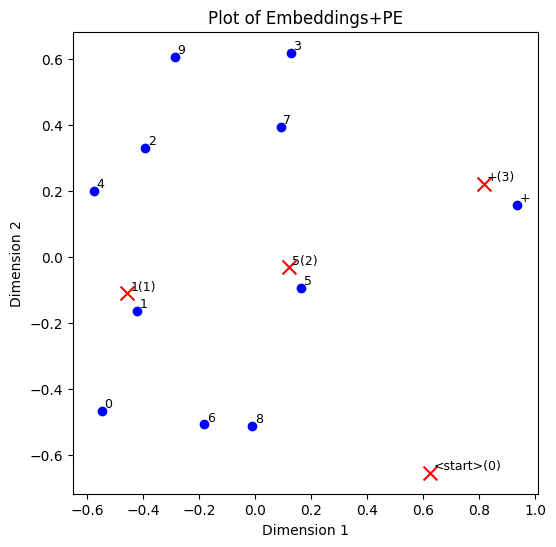

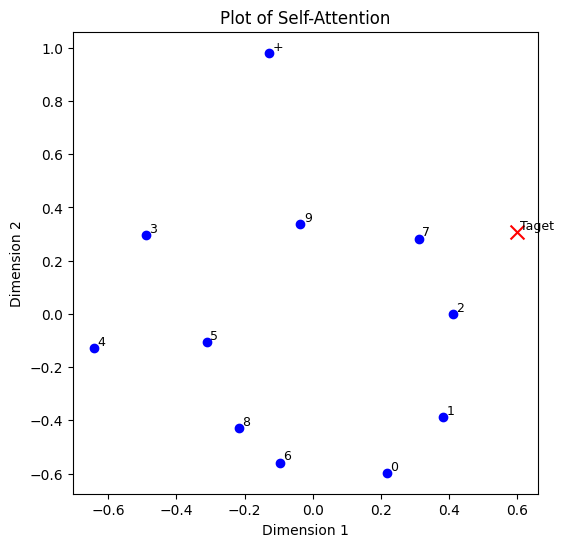

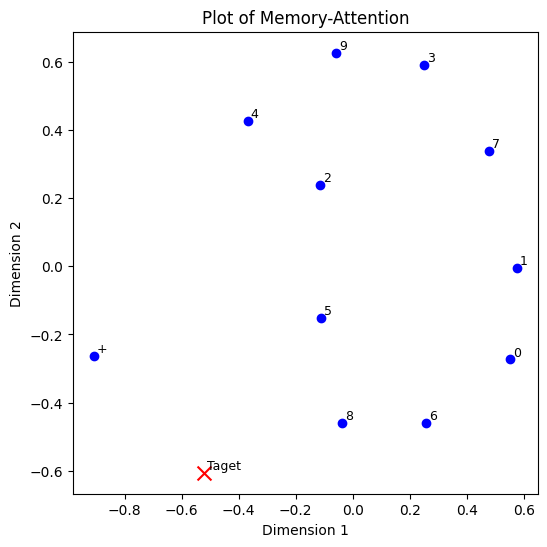

output.shape: torch.Size([1, 15])
output: tensor([[ 1.5272e-02, -9.7315e+00,  2.1357e+00, -3.4209e+00, -4.7462e+00,  3.5493e+00,  1.2454e+00,
         -5.5559e+00,  1.5947e+01, -7.9248e+00,  1.0570e+01, -4.2099e+00, -5.9324e+00, -5.5276e+00,
         -4.3445e+00]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 8

------------------

iter: 4
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8]], device='cuda:0')


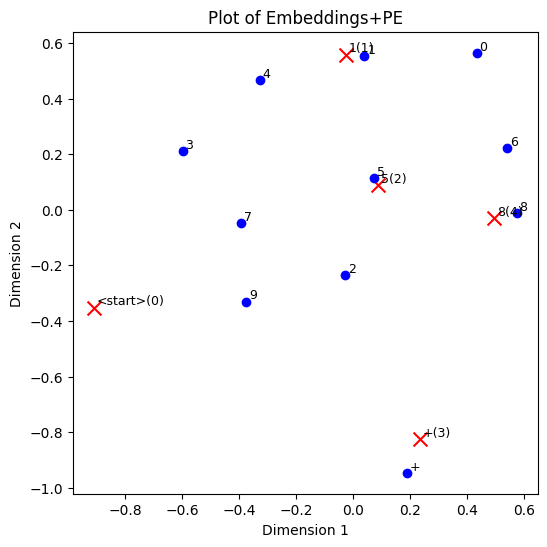

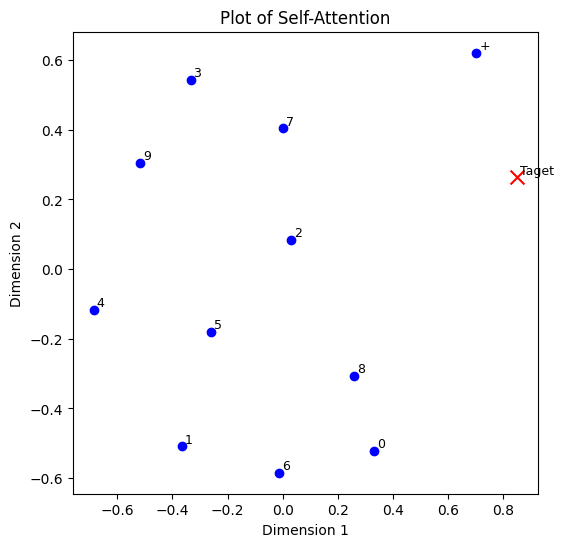

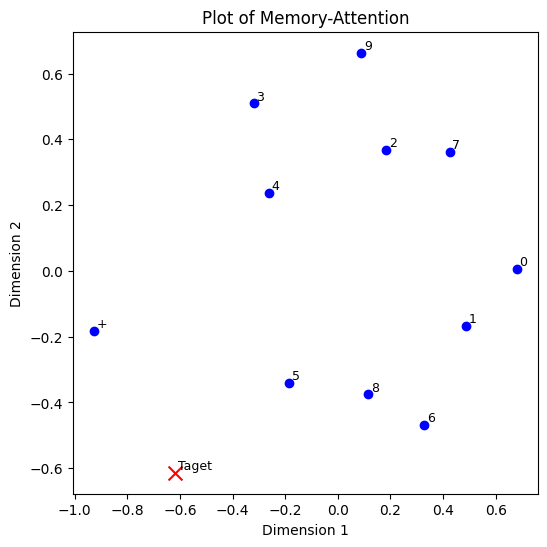

output.shape: torch.Size([1, 15])
output: tensor([[-11.0163,  -2.4999,  -5.2057,  -2.0873,  -3.8904,  11.3098,  -2.5003,  -1.1206,  -0.1997,
         -10.5451,   8.3833,  -3.9191, -13.7734,  -7.7351,  -7.0831]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 5
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5]], device='cuda:0')


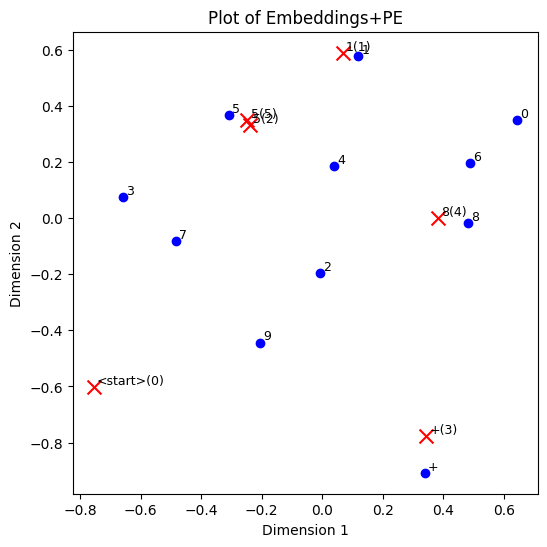

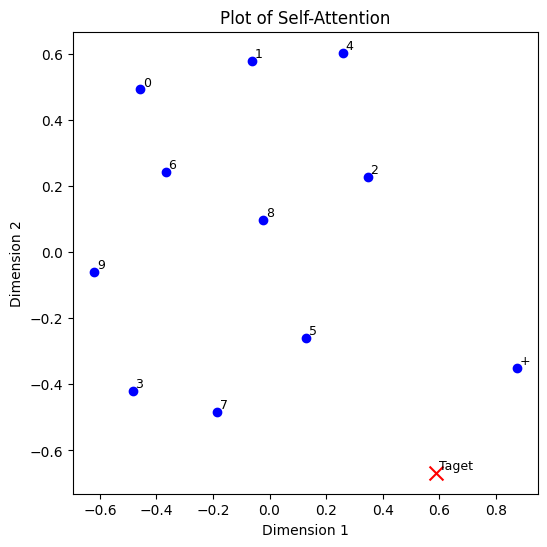

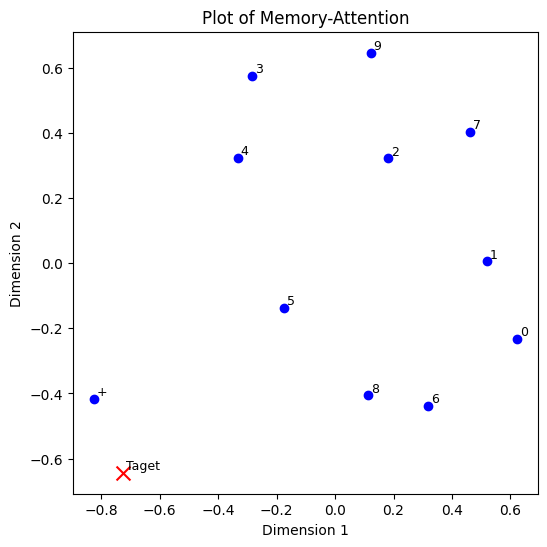

output.shape: torch.Size([1, 15])
output: tensor([[-10.1618,  -6.3455,  -6.9950,  -6.2857,  -7.2746,   1.1007,  -6.3389,  -5.4862,  -4.1070,
         -10.9314,  17.6399,  -8.4253,  -5.2060,  -7.7809,  -6.4111]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 6
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5],
        [10]], device='cuda:0')


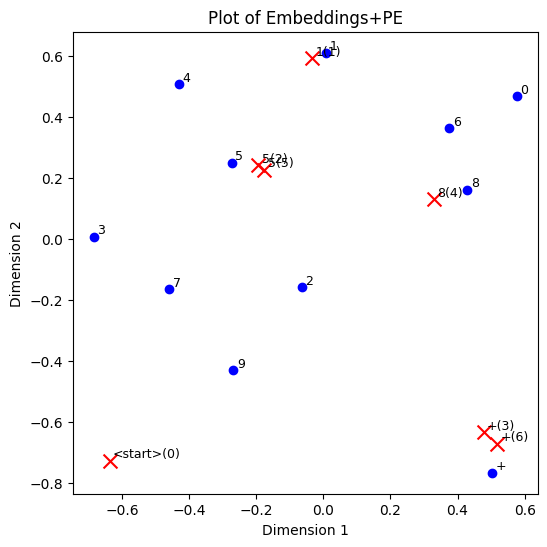

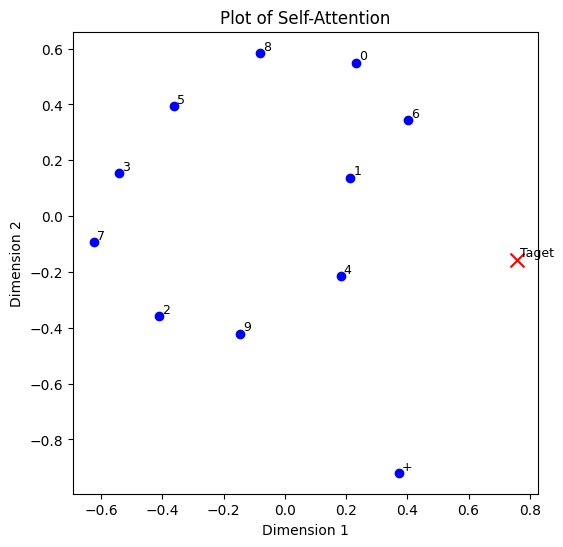

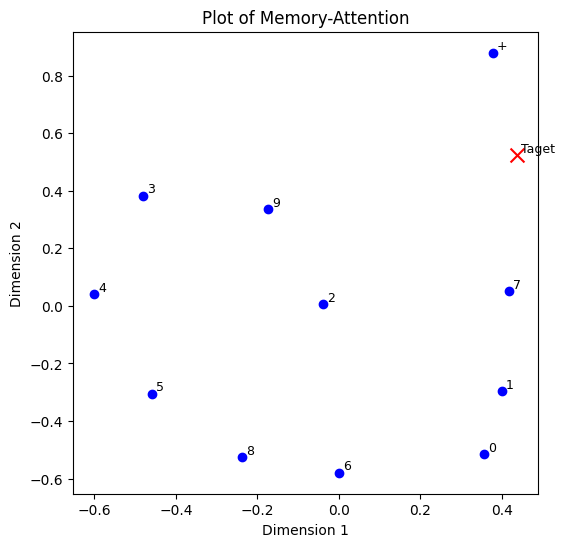

output.shape: torch.Size([1, 15])
output: tensor([[  0.9109,   2.0788,   0.7052,   0.7225,   0.8464,   1.7429,   1.1110,   1.4484,   0.4453,
           0.2056,  11.5483,  -5.0019, -35.3541, -10.6730, -10.8949]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 7
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5],
        [10],
        [10]], device='cuda:0')


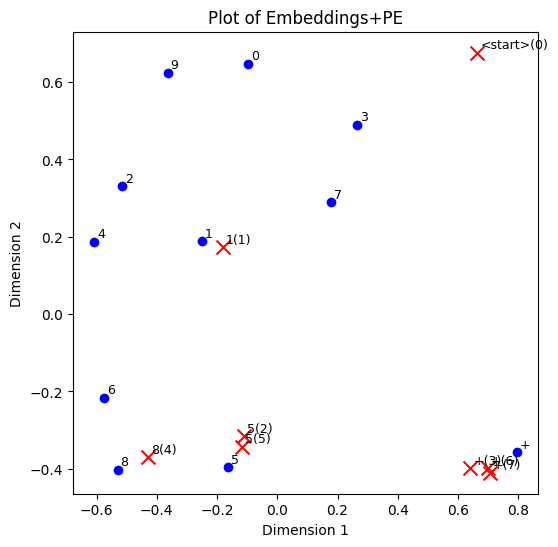

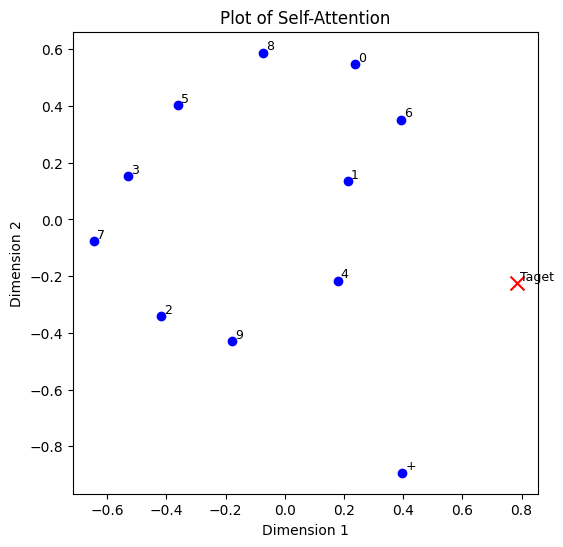

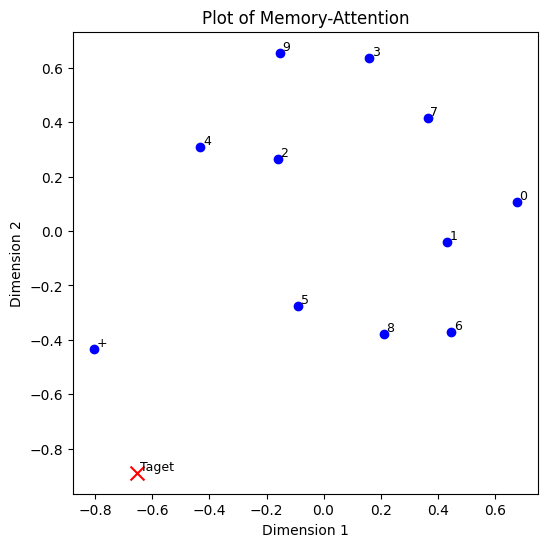

output.shape: torch.Size([1, 15])
output: tensor([[-12.5693,  -5.6521, -10.4536,  -8.3322,  -7.5729,   0.8850, -11.6564,  -9.5023,  -8.5385,
         -18.3990,  10.0677,  -0.7405,  27.2239,  -5.1709,  -1.3726]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 12

------------------



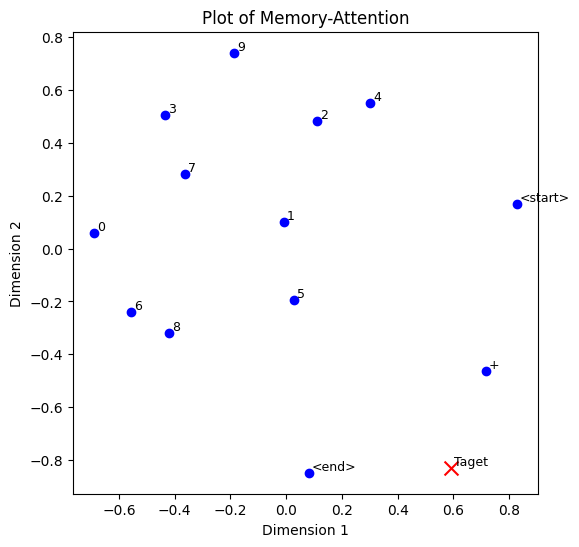

Input: ++15+85
Decoded sequence: 15+85++


In [175]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d ,ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=tgt_embed, title="E+PE")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt_embed, title="Embeddings+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[-1:, :], title="Self-Attention")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[-1:, :], title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break

# 最後に<end>の埋め込みまで計算
plot_embedding_tgt_2d(embedded_weight=embedding_weight[:13, :], ys=ys, tgt_embed=tgt[-1:, :], src=src, title="Memory-Attention")

flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

### PCAを利用

torch.Size([11, 16])


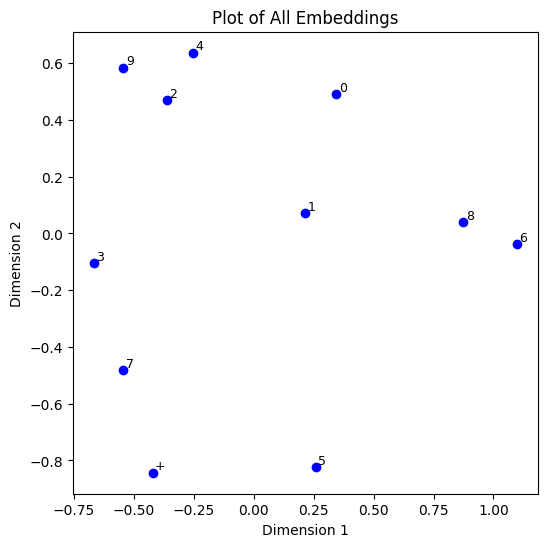

torch.Size([13, 16])


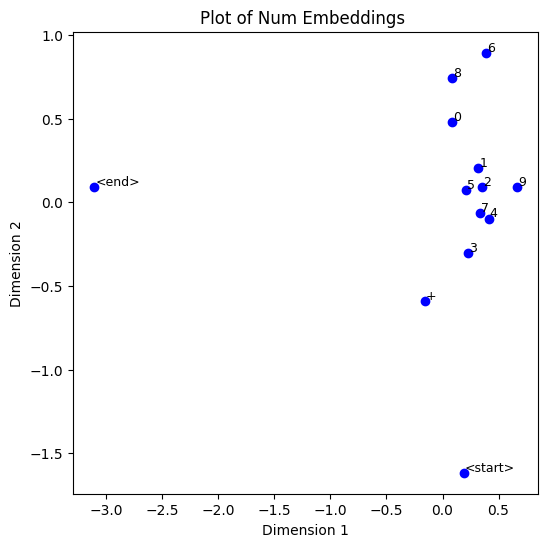

In [116]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# PCAを使って埋め込みベクトルを2次元に圧縮する関数
def apply_pca(embedding_weight, n_components=2):
    print(embedding_weight.shape)
    pca = PCA(n_components=n_components)
    embedding_2d = pca.fit_transform(embedding_weight.cpu().detach().numpy())
    return embedding_2d


# 逆辞書を作成
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

# 2次元に圧縮した埋め込みベクトルのプロット
# 2次元に圧縮した埋め込みベクトルのプロット
def plot_embedding_tgt_2d(embedded_weight, ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))
    embedded_weight = embedded_weight.cpu().detach()


    if tgt_embed is not None:
        # TensorのままPCAを適用する
        tgt_embed = tgt_embed.cpu().detach()
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=1)
        
        # embedded_weightとtgt_embedを結合しPCAを適用
        print(embedded_weight.shape)
        print(tgt_embed.shape)
        embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
        tgt_embed_2d = embed[-1:]
        embedded_weight_2d = embed[:-1]

        # ターゲット埋め込みベクトルをプロット
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i] + f"({i})"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, str(i) + label, fontsize=9)
    else:
        embedded_weight_2d = apply_pca(embedded_weight, n_components=2)

    # PCAで圧縮された埋め込みをプロット
    for i, (x, y) in enumerate(embedded_weight_2d):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


# プロットの実行
plot_embedding_tgt_2d(embedding_weight[:11, :], title="All Embeddings")
plot_embedding_tgt_2d(embedding_weight[:13, :], title="Num Embeddings ")


text: ++15+85
memory: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 1.2438, -0.6305,  0.6733, -0.1499,  0.0632, -1.0485, -0.8788,  1.9697, -1.9643,  2.9094,
           1.6526,  1.9463, -0.0815, -0.0498, -1.0288, -0.8098]],

        [[ 1.3117, -1.5870,  0.9535, -0.2937,  0.1620, -1.0634, -0.8472,  1.9682, -1.9543,  2.9092,
           1.6557,  1.9462, -0.0805, -0.0498, -1.0284, -0.8098]],

        [[-0.1308, -1.6610,  1.7921,  1.3588,  1.3633,  1.3513,  1.1507, -0.2658,  1.4866, -1.6200,
          -0.4106,  3.7773, -1.0053,  2.5418, -1.7825,  0.3241]],

        [[-1.6037, -2.0266,  1.6321, -0.8564, -0.5159,  2.5766,  2.5450,  1.0492, -0.2088,  0.3382,
          -2.8308, -0.0130, -0.9135,  2.0900, -2.9896, -0.6002]],

        [[-0.5566, -0.8872,  1.3623, -1.1106,  0.4427, -1.1659, -0.7529,  1.9577, -1.9243,  2.9082,
           1.6652,  1.9461, -0.0775, -0.049

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


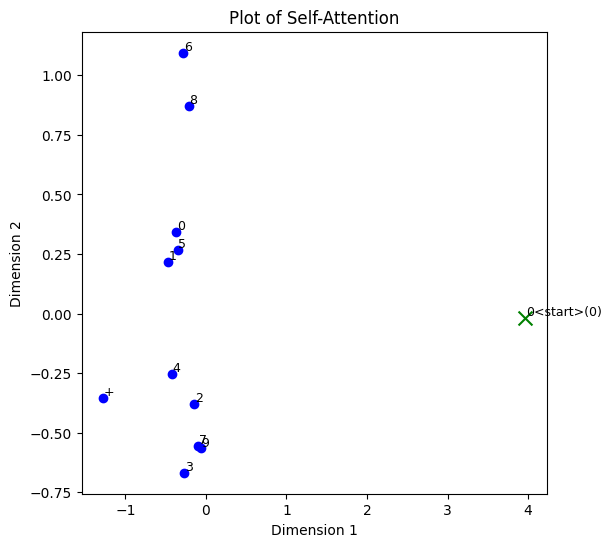

QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 16])
After Attention: tensor([[[ 0.7238, -0.1362, -0.1172, -0.1552,  2.6647,  4.0477,  0.6511, -4.9560,  0.0885, -6.8749,
           2.6044, 10.2784, -3.0005,  0.3599, -1.8107, -1.7910]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 16])
torch.Size([1, 16])
torch.Size([12, 16])


/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


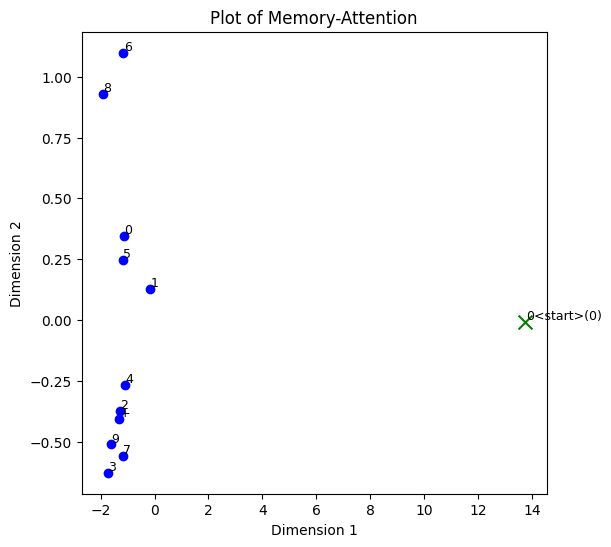

output.shape: torch.Size([1, 15])
output: tensor([[  1.6306,  16.1643,  -0.7687,  -7.2859,   2.1542,   0.8468,   1.3389,   0.9876, -10.2412,
          -5.8439,  -1.8741,   1.5282,  -2.9181,  -3.7561,  -3.7588]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 1
ys: tensor([[11],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]]], device='cuda:0')
now tgt: 1
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


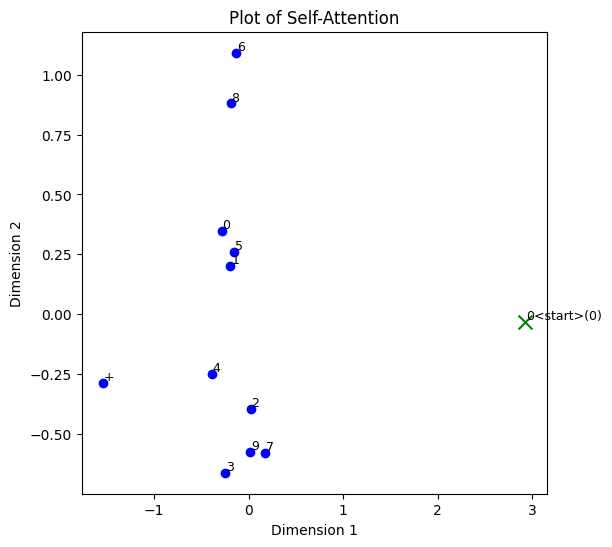

QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 16])
After Attention: tensor([[[ 0.7226, -0.1368, -0.1174, -0.1567,  2.6650,  4.0471,  0.6507, -4.9565,  0.0890, -6.8747,
           2.6064, 10.2787, -2.9987,  0.3603, -1.8107, -1.7910]],

        [[ 1.6637, -1.4218,  1.4624, -3.9969, -6.8219,  8.9976,  6.3964,  0.4784, -4.4423,  0.2216,
          -2.2038,  1.8306, -1.0234,  1.0104, -1.2483, -2.3386]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 16])
torch.Size([1, 16])
torch.Size([12, 16])


/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


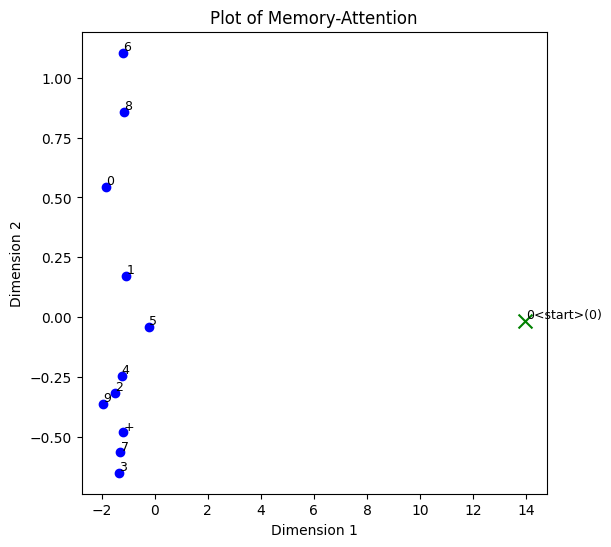

output.shape: torch.Size([1, 15])
output: tensor([[-10.1678,   1.6543,  -5.1334,  -2.5176,  -1.2350,  14.4051,  -0.0382,  -1.7389,   0.5393,
         -11.9568,  -1.1005,   1.7356,   1.3199,  -4.8138,  -3.4137]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 2
ys: tensor([[11],
        [ 1],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]]], device='cuda:0')
now tgt: 15
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


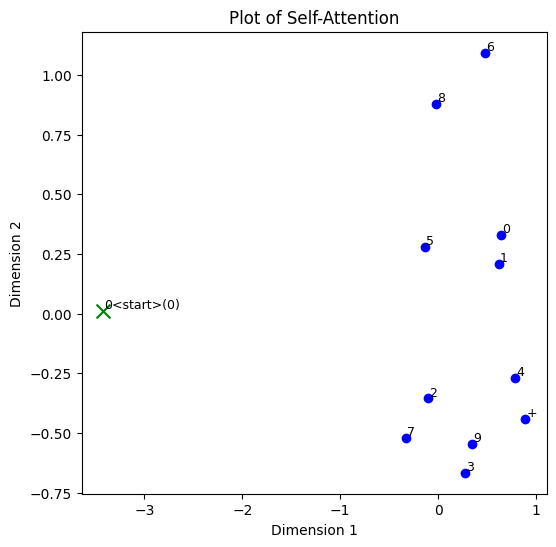

QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 16])
After Attention: tensor([[[ 0.7210, -0.1375, -0.1178, -0.1585,  2.6660,  4.0458,  0.6498, -4.9571,  0.0895, -6.8748,
           2.6095, 10.2792, -2.9958,  0.3607, -1.8107, -1.7907]],

        [[ 1.9148, -1.3693,  1.8696, -4.0737, -7.0355,  8.2502,  6.6577,  1.1669, -5.0318,  0.2003,
          -1.8660,  2.0090, -0.7736,  0.6278, -1.3440, -2.6102]],

        [[ 2.9857, -3.3102,  3.9251, -6.6919, -5.7086, -1.9978,  4.7019,  6.8187, -8.1251,  4.2618,
           3.9365, -0.2481,  4.8058, -2.0627, -0.9318, -2.8961]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 16])
torch.Size([1, 16])
torch.Size([12, 16])


/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


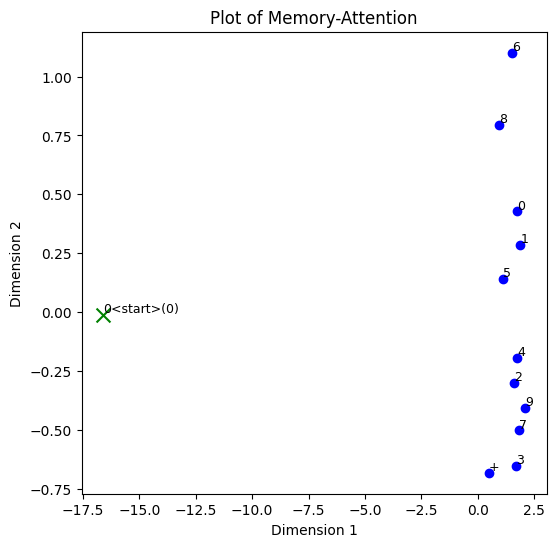

output.shape: torch.Size([1, 15])
output: tensor([[ -7.2912, -10.0525,  -5.1980,  -6.7646,  -7.5076,   3.7686,  -3.0530,  -8.9098,   7.1112,
         -14.1574,  14.7239,  -1.7201,   3.8108,  -6.2149,  -3.9472]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 3
ys: tensor([[11],
        [ 1],
        [ 5],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0.8156,  1.9657, -1.9443,  2.9090,
        

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


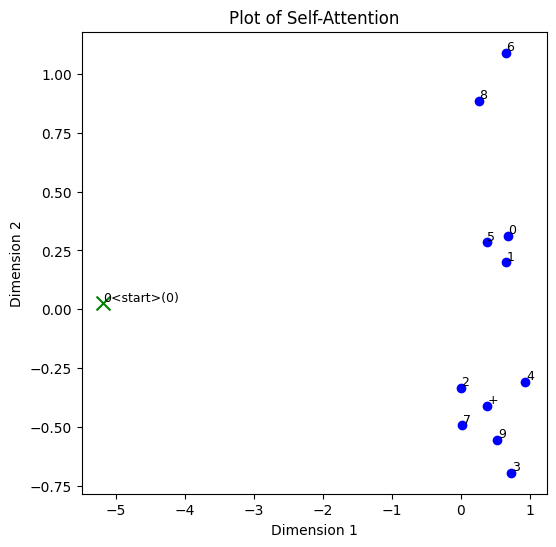

QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 16])
After Attention: tensor([[[ 0.7323, -0.1079, -0.1224, -0.1230,  2.6772,  4.0141,  0.6293, -4.9534,  0.0839, -6.8857,
           2.6074, 10.2871, -3.0019,  0.3419, -1.8095, -1.7887]],

        [[ 2.8808, -0.6277,  0.2643, -3.5677, -5.4094,  9.2057,  5.3892, -0.9664, -6.1442, -0.3128,
          -0.0880,  4.6343, -3.3347,  0.3694, -1.3753, -1.8177]],

        [[ 4.3781, -0.2136, -0.8768, -4.2775, -4.7684,  5.5129,  4.7626, -0.3949, -9.2261, -0.3005,
           4.4664,  6.0943, -3.3969, -0.3507, -1.4480, -0.6628]],

        [[ 0.8420, -4.3061,  6.3110, -5.4915, -5.4986, -4.5525,  3.8021,  7.4344, -2.6533,  1.8927,
           3.6310, -4.8412,  7.1235, -1.4411, -0.8483, -1.7990]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([11, 16])
torch.Size([1, 16])
torch.Size([12, 16])


/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


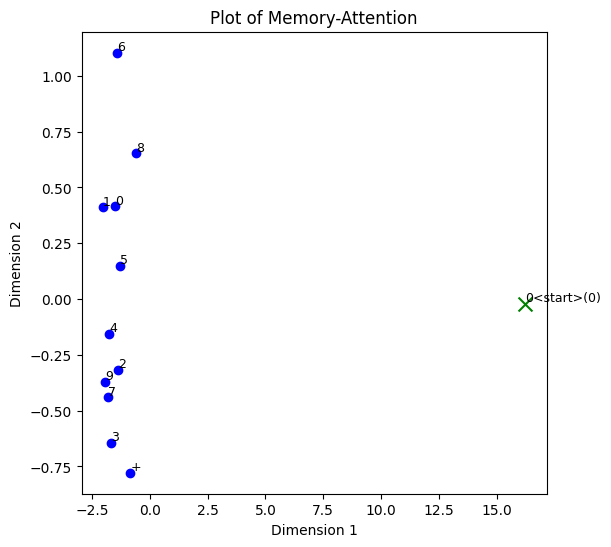

output.shape: torch.Size([1, 15])
output: tensor([[ 1.5272e-02, -9.7315e+00,  2.1357e+00, -3.4209e+00, -4.7462e+00,  3.5493e+00,  1.2454e+00,
         -5.5559e+00,  1.5947e+01, -7.9248e+00,  1.0570e+01, -4.2099e+00, -5.9324e+00, -5.5276e+00,
         -4.3445e+00]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 8

------------------

iter: 4
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


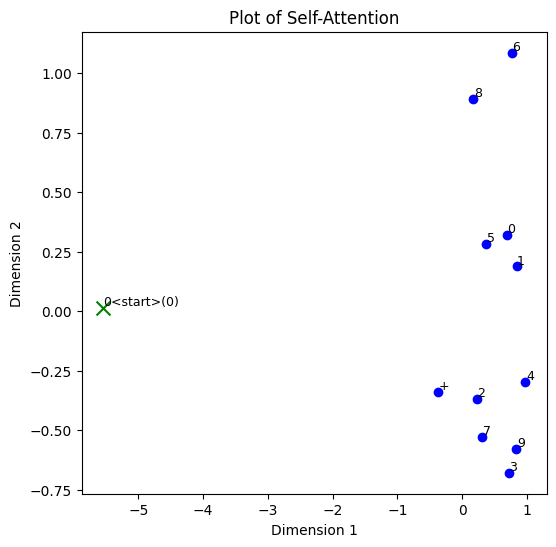

QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 16])
After Attention: tensor([[[ 7.3192e-01, -1.0795e-01, -1.2248e-01, -1.2340e-01,  2.6775e+00,  4.0138e+00,  6.2915e-01,
          -4.9536e+00,  8.4076e-02, -6.8858e+00,  2.6081e+00,  1.0287e+01, -3.0012e+00,  3.4192e-01,
          -1.8095e+00, -1.7887e+00]],

        [[ 2.9900e+00, -6.6017e-01,  2.7628e-01, -3.8179e+00, -5.6276e+00,  9.0022e+00,  5.4746e+00,
          -7.1083e-01, -6.5141e+00, -2.6282e-03,  1.9496e-01,  4.4246e+00, -3.1836e+00,  3.0941e-01,
          -1.3670e+00, -1.7473e+00]],

        [[ 5.0847e+00, -5.2036e-01, -4.9395e-01, -5.7113e+00, -5.5364e+00,  7.3877e-01,  4.2824e+00,
           2.5851e+00, -1.1133e+01,  2.3848e+00,  7.2079e+00,  3.2323e+00, -1.0863e+00, -1.1576e+00,
          -1.1426e+00,  1.9403e-01]],

        [[ 1.3611e+00, -4.5436e+00,  7.3600e+00, -7.8267e+00, -5.8493e+00,  1.7390e+00,

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


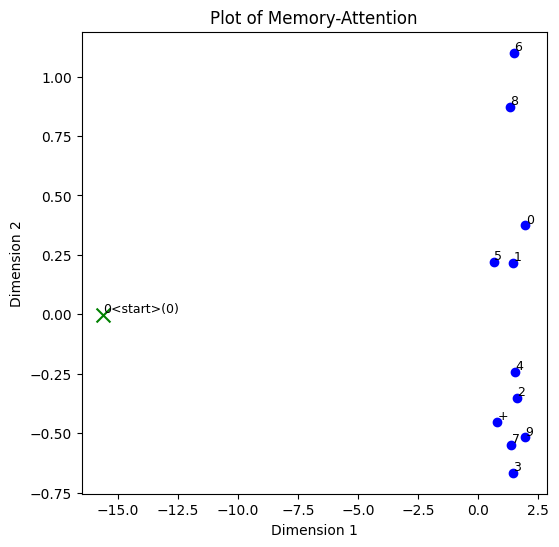

output.shape: torch.Size([1, 15])
output: tensor([[-11.0163,  -2.4999,  -5.2057,  -2.0873,  -3.8904,  11.3098,  -2.5003,  -1.1206,  -0.1997,
         -10.5451,   8.3833,  -3.9191, -13.7734,  -7.7351,  -7.0831]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 5
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0.8156,  1.9657,

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


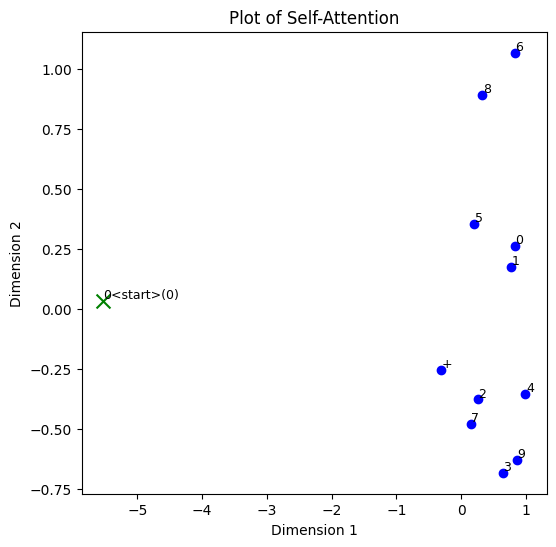

QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 16])
After Attention: tensor([[[  0.7272,  -0.1094,  -0.1238,  -0.1298,   2.6805,   4.0108,   0.6271,  -4.9554,   0.0858,
           -6.8857,   2.6163,  10.2886,  -2.9929,   0.3433,  -1.8096,  -1.7882]],

        [[  3.1792,  -0.7214,   0.3268,  -4.2436,  -6.0073,   8.5547,   5.6055,  -0.2248,  -7.1200,
            0.5211,   0.6899,   4.0400,  -2.8851,   0.2039,  -1.3529,  -1.6278]],

        [[  4.3864,  -1.6009,   2.3122,  -6.5263,  -6.0458,  -3.2809,   3.7968,   5.9446,  -9.5652,
            3.9901,   7.0608,  -0.9439,   2.5607,  -1.9700,  -0.9464,  -0.1615]],

        [[  1.6716,  -4.2103,   7.1300,  -8.3031,  -5.4432,   4.3637,   4.0560,   3.8413,  -3.7815,
            4.7465,   0.7547,   0.1665,   3.9443,  -1.3713,  -2.1317,  -3.6255]],

        [[  2.2622,  -3.6148,   6.6626,  -8.9271,  -3.8122,   5.7664,   3.0581

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


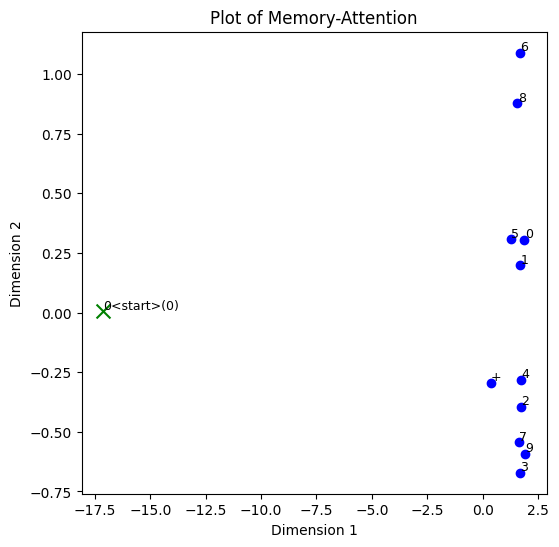

output.shape: torch.Size([1, 15])
output: tensor([[-10.1618,  -6.3455,  -6.9950,  -6.2857,  -7.2746,   1.1007,  -6.3389,  -5.4862,  -4.1070,
         -10.9314,  17.6399,  -8.4253,  -5.2060,  -7.7809,  -6.4111]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 6
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


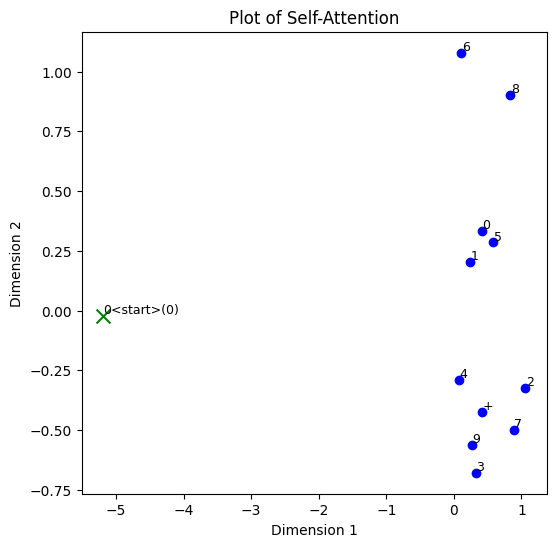

QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 16])
After Attention: tensor([[[  0.7486,  -0.0625,  -0.1263,  -0.0747,   2.6886,   3.9737,   0.6028,  -4.9474,   0.0735,
           -6.8973,   2.5990,  10.2992,  -3.0129,   0.3157,  -1.8084,  -1.7882]],

        [[  3.5969,  -0.6978,   0.2621,  -4.6506,  -6.5301,   7.7002,   5.6989,   0.5022,  -7.9907,
            1.4435,   1.2250,   3.3862,  -2.6924,   0.0175,  -1.2450,  -1.4005]],

        [[  4.9213,  -0.8815,   0.4878,  -6.0693,  -6.3636,  -1.1320,   4.3217,   4.4494, -10.7646,
            3.7112,   6.8345,   0.6620,   0.4126,  -1.4146,  -0.8852,   0.1755]],

        [[  2.4040,  -4.2600,   7.8516,  -7.4365,  -5.6696,   2.2525,   4.1732,   5.3516,  -4.6029,
            4.2193,   1.5493,  -0.6154,   3.8238,  -2.2647,  -1.9662,  -3.5307]],

        [[  2.0711,  -3.5523,   6.7265,  -8.3126,  -4.4077,   6.6339,   3.4312

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


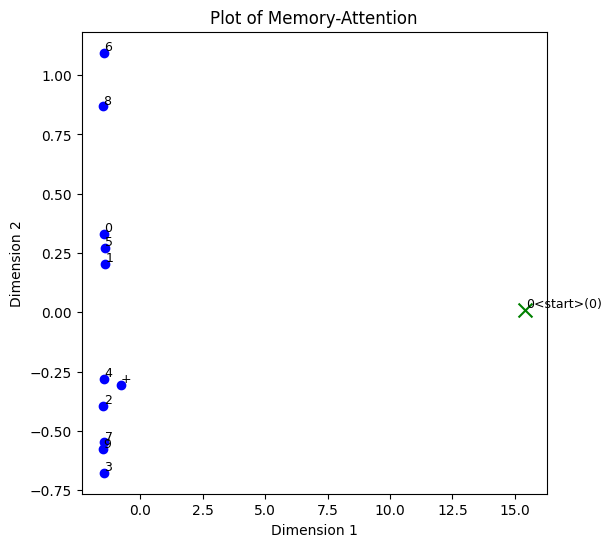

output.shape: torch.Size([1, 15])
output: tensor([[  0.9109,   2.0788,   0.7052,   0.7225,   0.8464,   1.7429,   1.1110,   1.4484,   0.4453,
           0.2056,  11.5483,  -5.0019, -35.3541, -10.6730, -10.8949]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 7
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5],
        [10],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.258

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


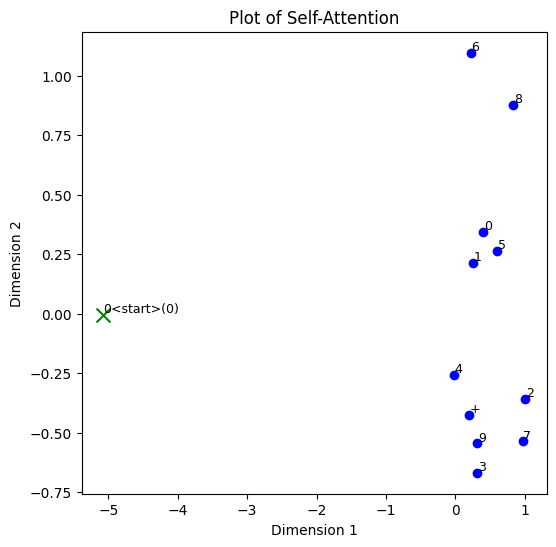

QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 16])
After Attention: tensor([[[  0.7611,  -0.0411,  -0.1257,  -0.0450,   2.6890,   3.9589,   0.5928,  -4.9423,   0.0653,
           -6.9024,   2.5870,  10.3039,  -3.0260,   0.3015,  -1.8077,  -1.7885]],

        [[  3.4113,  -0.7476,   0.4437,  -4.3908,  -6.4184,   8.1694,   5.7183,   0.2500,  -7.4800,
            1.0749,   0.6890,   3.5376,  -2.8030,   0.0821,  -1.2718,  -1.5786]],

        [[  4.8412,  -0.8204,   0.4461,  -5.8461,  -6.7742,   1.3023,   5.0390,   3.4672, -10.6554,
            2.8610,   5.7421,   1.7063,  -0.5307,  -1.1071,  -1.0524,  -0.2069]],

        [[  3.9237,  -2.6322,   4.9913,  -7.0012,  -6.9983,   1.2526,   4.7520,   5.3519,  -8.0329,
            4.5019,   3.4802,  -0.2151,   2.2359,  -2.1558,  -1.5602,  -2.0942]],

        [[  2.0594,  -3.5439,   6.7855,  -8.1509,  -4.5005,   6.7579,   3.4911

/tmp/ipykernel_258924/3520452500.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_pca(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)


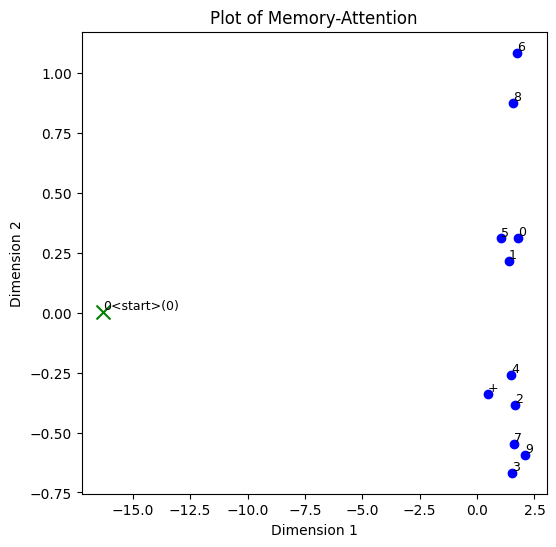

output.shape: torch.Size([1, 15])
output: tensor([[-12.5693,  -5.6521, -10.4536,  -8.3322,  -7.5729,   0.8850, -11.6564,  -9.5023,  -8.5385,
         -18.3990,  10.0677,  -0.7405,  27.2239,  -5.1709,  -1.3726]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 12

------------------

Input: ++15+85
Decoded sequence: 15+85++


In [119]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d ,ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[-1:, :], title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    print(f"After Attention: {tgt}")
    # Memory-Attentionのベクトルの可視化
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[-1:, :], src=src, title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)
    output = loaded_model.compute_output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

### t-SNE

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


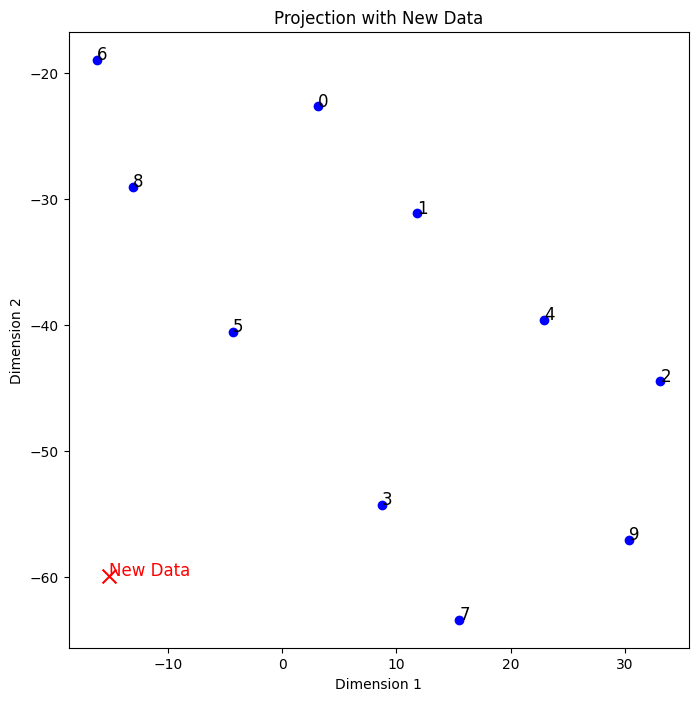

In [145]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# 既存の0-9のデータベクトル
existing_vectors = embedding_weight[:10, :].cpu()  # 0-9の既存データ（仮）

# 新しいデータ
new_data = torch.randn(1, embedding_weight.shape[1])  # ランダムに生成した新しいデータ（仮）

# t-SNEを使って既存のデータを2次元に圧縮
def apply_tsne(existing_vectors, new_data, n_components=2, perplexity=5, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    combined_data = torch.cat((existing_vectors, new_data), dim=0).cpu().detach().numpy()  # 既存のデータと新しいデータを結合
    embedding_2d = tsne.fit_transform(combined_data)
    return embedding_2d

# 類似度に基づいてプロットの位置を決定する関数
def plot_similarity_projection(embedding_2d, reverse_vocab, new_data_idx=-1, title="Projection with New Data"):
    plt.figure(figsize=(8, 8))
    
    # 既存のデータをプロット
    for i, (x, y) in enumerate(embedding_2d[:-1]):  # 新しいデータを除く
        label = reverse_vocab[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=12)
    
    # 新しいデータをプロット（赤色で表示）
    new_x, new_y = embedding_2d[new_data_idx]
    plt.scatter(new_x, new_y, color='red', s=100, marker='x')
    plt.text(new_x + 0.01, new_y + 0.01, "New Data", fontsize=12, color='red')

    plt.title(f"{title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# t-SNEで2次元に射影
embedding_2d = apply_tsne(existing_vectors, new_data)

# プロットの実行（新しいデータがどの位置にあるか）
reverse_vocab_src = {i: str(i) for i in range(10)}  # 0-9のラベル（仮）
plot_similarity_projection(embedding_2d, reverse_vocab_src, new_data_idx=-1)


torch.Size([11, 16])


/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


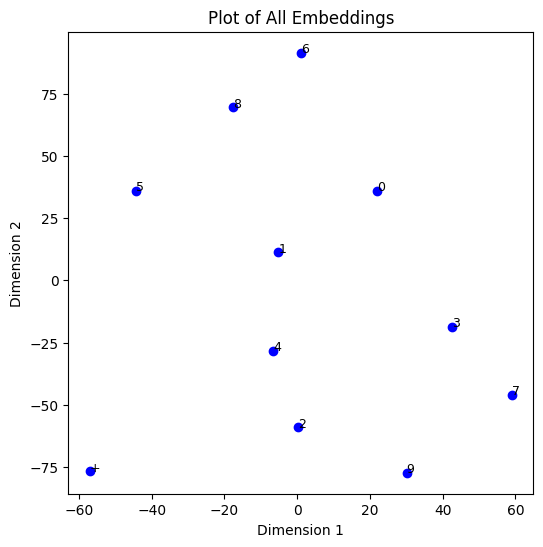

torch.Size([13, 16])


/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


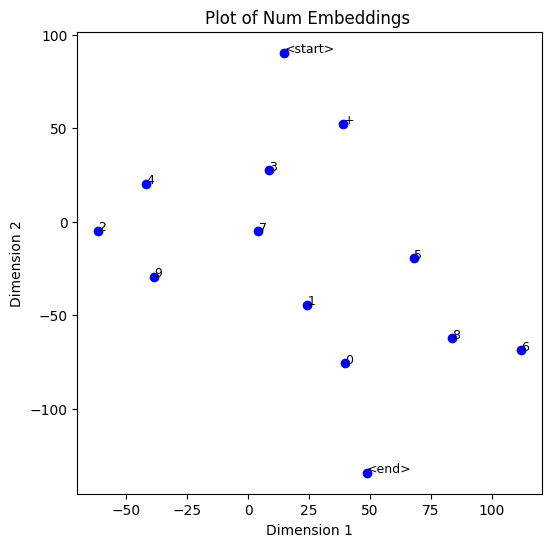

In [143]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# t-SNEを使って埋め込みベクトルを2次元に圧縮する関数
def apply_tsne(embedding_weight, n_components=2, perplexity=5, n_iter=1000):
    print(embedding_weight.shape)
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    embedding_2d = tsne.fit_transform(embedding_weight.cpu().detach().numpy())
    return embedding_2d


# 逆辞書を作成
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

# 2次元に圧縮した埋め込みベクトルのプロット
# 2次元に圧縮した埋め込みベクトルのプロット
def plot_embedding_tgt_2d(embedded_weight, ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))
    embedded_weight = embedded_weight.cpu().detach()


    if tgt_embed is not None:
        # TensorのままPCAを適用する
        tgt_embed = tgt_embed.cpu().detach()
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = torch.squeeze(tgt_embed, dim=1)
        
        # embedded_weightとtgt_embedを結合しPCAを適用
        embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
        tgt_embed_2d = embed[-len(tgt_embed):]
        embedded_weight_2d = embed[:-len(tgt_embed)]

        # ターゲット埋め込みベクトルをプロット
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i]
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i]
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, label, fontsize=9)
    else:
        embedded_weight_2d = apply_tsne(embedded_weight, n_components=2)

    # PCAで圧縮された埋め込みをプロット
    for i, (x, y) in enumerate(embedded_weight_2d):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


# プロットの実行
plot_embedding_tgt_2d(embedding_weight[:11, :], title="All Embeddings")
plot_embedding_tgt_2d(embedding_weight[:13, :], title="Num Embeddings ")


text: ++15+85
memory: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 1.2438, -0.6305,  0.6733, -0.1499,  0.0632, -1.0485, -0.8788,  1.9697, -1.9643,  2.9094,
           1.6526,  1.9463, -0.0815, -0.0498, -1.0288, -0.8098]],

        [[ 1.3117, -1.5870,  0.9535, -0.2937,  0.1620, -1.0634, -0.8472,  1.9682, -1.9543,  2.9092,
           1.6557,  1.9462, -0.0805, -0.0498, -1.0284, -0.8098]],

        [[-0.1308, -1.6610,  1.7921,  1.3588,  1.3633,  1.3513,  1.1507, -0.2658,  1.4866, -1.6200,
          -0.4106,  3.7773, -1.0053,  2.5418, -1.7825,  0.3241]],

        [[-1.6037, -2.0266,  1.6321, -0.8564, -0.5159,  2.5766,  2.5450,  1.0492, -0.2088,  0.3382,
          -2.8308, -0.0130, -0.9135,  2.0900, -2.9896, -0.6002]],

        [[-0.5566, -0.8872,  1.3623, -1.1106,  0.4427, -1.1659, -0.7529,  1.9577, -1.9243,  2.9082,
           1.6652,  1.9461, -0.0775, -0.049

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


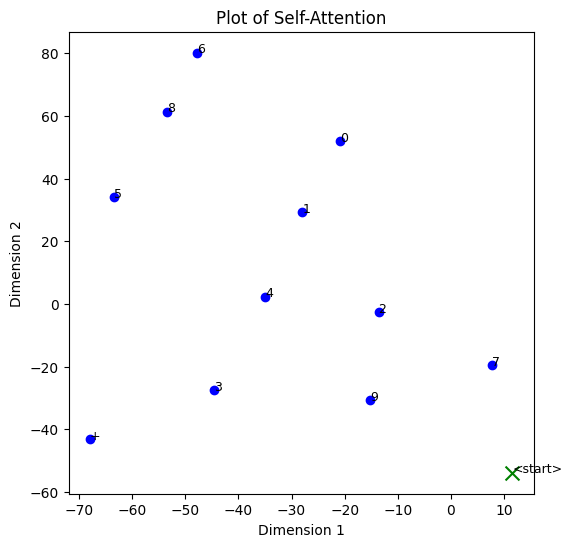

QV.shape: torch.Size([1, 1, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 1, 9])
AV.shape: torch.Size([1, 1, 16])
After Attention: tensor([[[ 0.7238, -0.1362, -0.1172, -0.1552,  2.6647,  4.0477,  0.6511, -4.9560,  0.0885, -6.8749,
           2.6044, 10.2784, -3.0005,  0.3599, -1.8107, -1.7910]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([12, 16])


/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


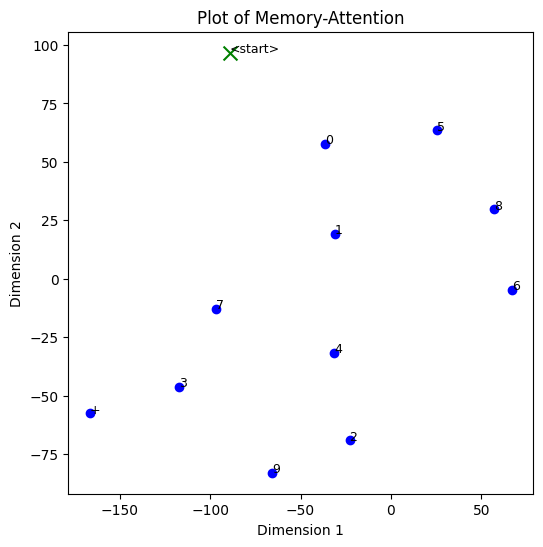

output.shape: torch.Size([1, 15])
output: tensor([[  1.6306,  16.1643,  -0.7687,  -7.2859,   2.1542,   0.8468,   1.3389,   0.9876, -10.2412,
          -5.8439,  -1.8741,   1.5282,  -2.9181,  -3.7561,  -3.7588]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 1

------------------

iter: 1
ys: tensor([[11],
        [ 1]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]]], device='cuda:0')
now tgt: 1
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


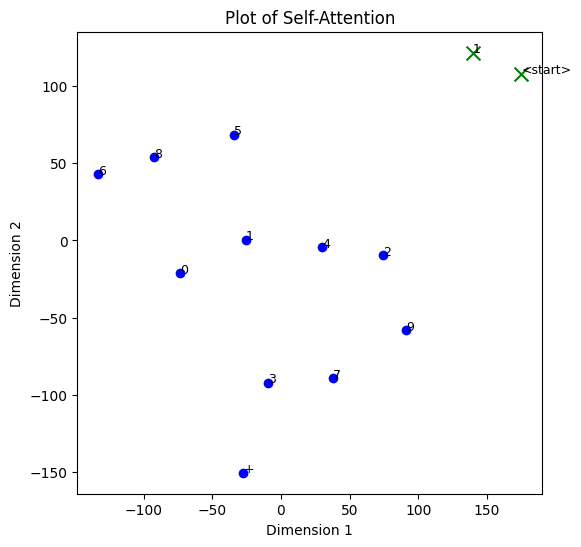

QV.shape: torch.Size([1, 2, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 2, 9])
AV.shape: torch.Size([1, 2, 16])
After Attention: tensor([[[ 0.7226, -0.1368, -0.1174, -0.1567,  2.6650,  4.0471,  0.6507, -4.9565,  0.0890, -6.8747,
           2.6064, 10.2787, -2.9987,  0.3603, -1.8107, -1.7910]],

        [[ 1.6637, -1.4218,  1.4624, -3.9969, -6.8219,  8.9976,  6.3964,  0.4784, -4.4423,  0.2216,
          -2.2038,  1.8306, -1.0234,  1.0104, -1.2483, -2.3386]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([13, 16])


/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


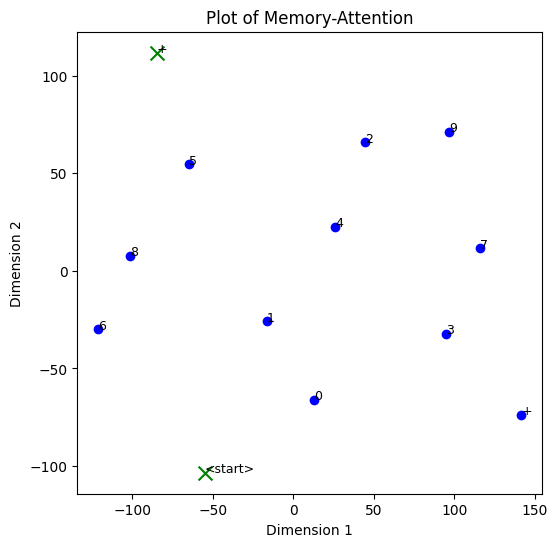

output.shape: torch.Size([1, 15])
output: tensor([[-10.1678,   1.6543,  -5.1334,  -2.5176,  -1.2350,  14.4051,  -0.0382,  -1.7389,   0.5393,
         -11.9568,  -1.1005,   1.7356,   1.3199,  -4.8138,  -3.4137]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 2
ys: tensor([[11],
        [ 1],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]]], device='cuda:0')
now tgt: 15
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


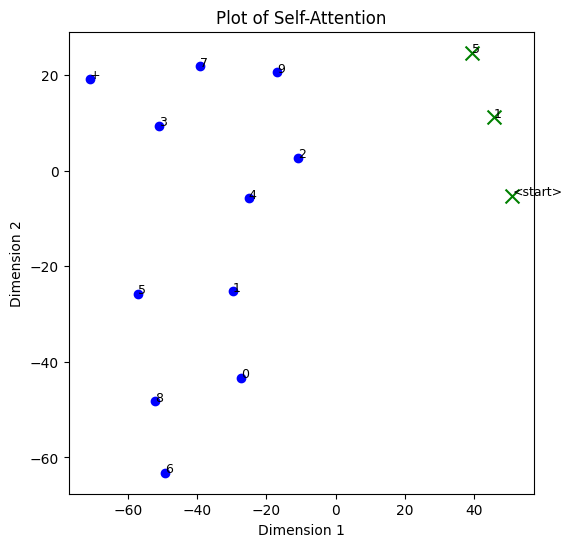

QV.shape: torch.Size([1, 3, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 3, 9])
AV.shape: torch.Size([1, 3, 16])
After Attention: tensor([[[ 0.7210, -0.1375, -0.1178, -0.1585,  2.6660,  4.0458,  0.6498, -4.9571,  0.0895, -6.8748,
           2.6095, 10.2792, -2.9958,  0.3607, -1.8107, -1.7907]],

        [[ 1.9148, -1.3693,  1.8696, -4.0737, -7.0355,  8.2502,  6.6577,  1.1669, -5.0318,  0.2003,
          -1.8660,  2.0090, -0.7736,  0.6278, -1.3440, -2.6102]],

        [[ 2.9857, -3.3102,  3.9251, -6.6919, -5.7086, -1.9978,  4.7019,  6.8187, -8.1251,  4.2618,
           3.9365, -0.2481,  4.8058, -2.0627, -0.9318, -2.8961]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([14, 16])


/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


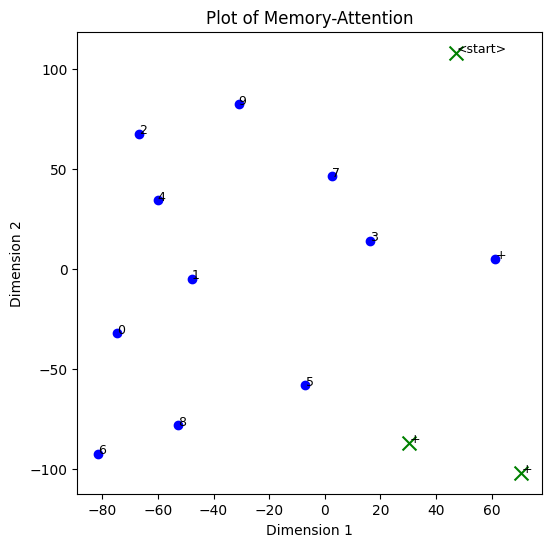

output.shape: torch.Size([1, 15])
output: tensor([[ -7.2912, -10.0525,  -5.1980,  -6.7646,  -7.5076,   3.7686,  -3.0530,  -8.9098,   7.1112,
         -14.1574,  14.7239,  -1.7201,   3.8108,  -6.2149,  -3.9472]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 3
ys: tensor([[11],
        [ 1],
        [ 5],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0.8156,  1.9657, -1.9443,  2.9090,
        

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


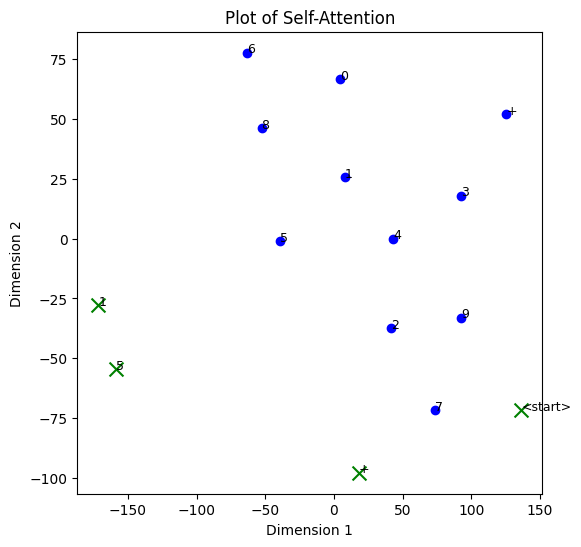

QV.shape: torch.Size([1, 4, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 4, 9])
AV.shape: torch.Size([1, 4, 16])
After Attention: tensor([[[ 0.7323, -0.1079, -0.1224, -0.1230,  2.6772,  4.0141,  0.6293, -4.9534,  0.0839, -6.8857,
           2.6074, 10.2871, -3.0019,  0.3419, -1.8095, -1.7887]],

        [[ 2.8808, -0.6277,  0.2643, -3.5677, -5.4094,  9.2057,  5.3892, -0.9664, -6.1442, -0.3128,
          -0.0880,  4.6343, -3.3347,  0.3694, -1.3753, -1.8177]],

        [[ 4.3781, -0.2136, -0.8768, -4.2775, -4.7684,  5.5129,  4.7626, -0.3949, -9.2261, -0.3005,
           4.4664,  6.0943, -3.3969, -0.3507, -1.4480, -0.6628]],

        [[ 0.8420, -4.3061,  6.3110, -5.4915, -5.4986, -4.5525,  3.8021,  7.4344, -2.6533,  1.8927,
           3.6310, -4.8412,  7.1235, -1.4411, -0.8483, -1.7990]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([15, 16])


/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


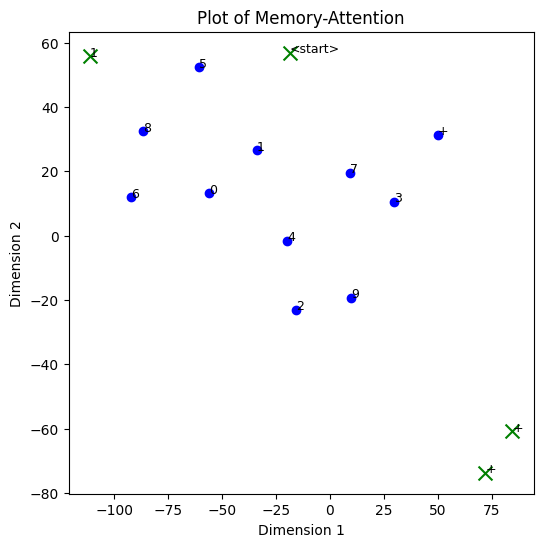

output.shape: torch.Size([1, 15])
output: tensor([[ 1.5272e-02, -9.7315e+00,  2.1357e+00, -3.4209e+00, -4.7462e+00,  3.5493e+00,  1.2454e+00,
         -5.5559e+00,  1.5947e+01, -7.9248e+00,  1.0570e+01, -4.2099e+00, -5.9324e+00, -5.5276e+00,
         -4.3445e+00]], device='cuda:0', grad_fn=<MmBackward0>)
predicted: 8

------------------

iter: 4
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


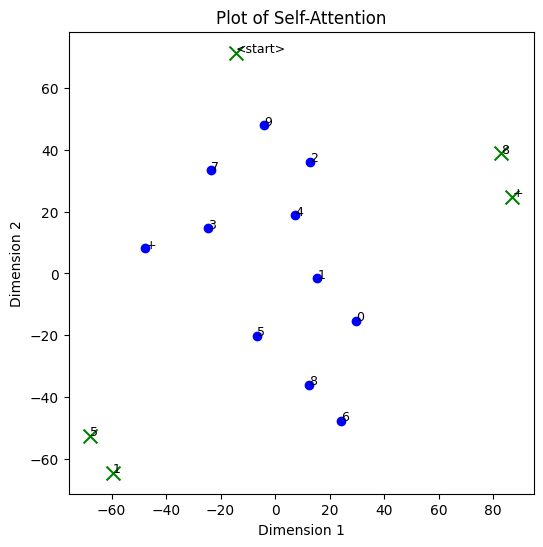

QV.shape: torch.Size([1, 5, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 5, 9])
AV.shape: torch.Size([1, 5, 16])
After Attention: tensor([[[ 7.3192e-01, -1.0795e-01, -1.2248e-01, -1.2340e-01,  2.6775e+00,  4.0138e+00,  6.2915e-01,
          -4.9536e+00,  8.4076e-02, -6.8858e+00,  2.6081e+00,  1.0287e+01, -3.0012e+00,  3.4192e-01,
          -1.8095e+00, -1.7887e+00]],

        [[ 2.9900e+00, -6.6017e-01,  2.7628e-01, -3.8179e+00, -5.6276e+00,  9.0022e+00,  5.4746e+00,
          -7.1083e-01, -6.5141e+00, -2.6282e-03,  1.9496e-01,  4.4246e+00, -3.1836e+00,  3.0941e-01,
          -1.3670e+00, -1.7473e+00]],

        [[ 5.0847e+00, -5.2036e-01, -4.9395e-01, -5.7113e+00, -5.5364e+00,  7.3877e-01,  4.2824e+00,
           2.5851e+00, -1.1133e+01,  2.3848e+00,  7.2079e+00,  3.2323e+00, -1.0863e+00, -1.1576e+00,
          -1.1426e+00,  1.9403e-01]],

        [[ 1.3611e+00, -4.5436e+00,  7.3600e+00, -7.8267e+00, -5.8493e+00,  1.7390e+00,

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


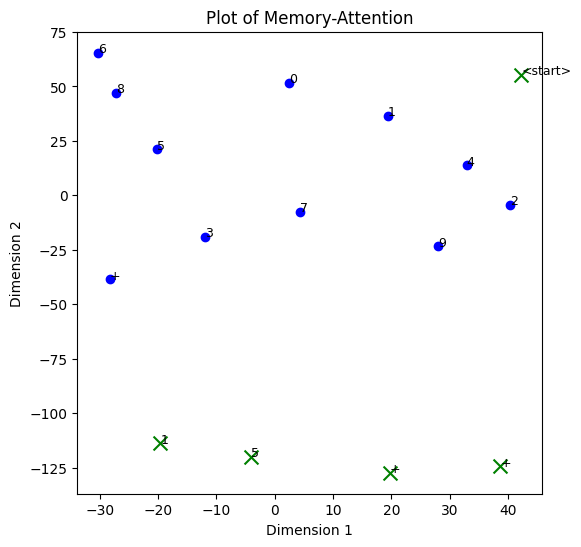

output.shape: torch.Size([1, 15])
output: tensor([[-11.0163,  -2.4999,  -5.2057,  -2.0873,  -3.8904,  11.3098,  -2.5003,  -1.1206,  -0.1997,
         -10.5451,   8.3833,  -3.9191, -13.7734,  -7.7351,  -7.0831]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 5

------------------

iter: 5
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0.8156,  1.9657,

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


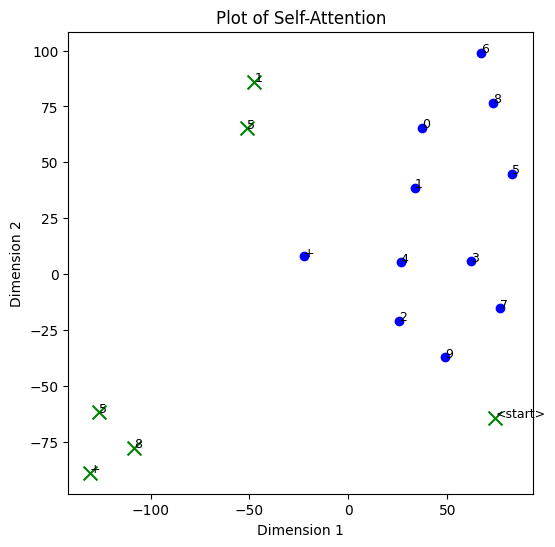

QV.shape: torch.Size([1, 6, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 6, 9])
AV.shape: torch.Size([1, 6, 16])
After Attention: tensor([[[  0.7272,  -0.1094,  -0.1238,  -0.1298,   2.6805,   4.0108,   0.6271,  -4.9554,   0.0858,
           -6.8857,   2.6163,  10.2886,  -2.9929,   0.3433,  -1.8096,  -1.7882]],

        [[  3.1792,  -0.7214,   0.3268,  -4.2436,  -6.0073,   8.5547,   5.6055,  -0.2248,  -7.1200,
            0.5211,   0.6899,   4.0400,  -2.8851,   0.2039,  -1.3529,  -1.6278]],

        [[  4.3864,  -1.6009,   2.3122,  -6.5263,  -6.0458,  -3.2809,   3.7968,   5.9446,  -9.5652,
            3.9901,   7.0608,  -0.9439,   2.5607,  -1.9700,  -0.9464,  -0.1615]],

        [[  1.6716,  -4.2103,   7.1300,  -8.3031,  -5.4432,   4.3637,   4.0560,   3.8413,  -3.7815,
            4.7465,   0.7547,   0.1665,   3.9443,  -1.3713,  -2.1317,  -3.6255]],

        [[  2.2622,  -3.6148,   6.6626,  -8.9271,  -3.8122,   5.7664,   3.0581

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


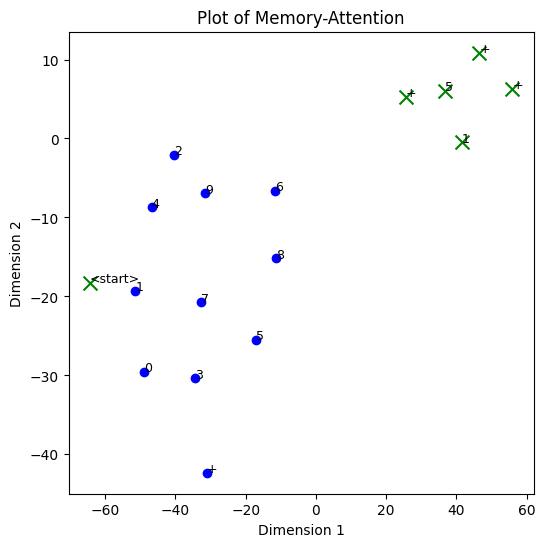

output.shape: torch.Size([1, 15])
output: tensor([[-10.1618,  -6.3455,  -6.9950,  -6.2857,  -7.2746,   1.1007,  -6.3389,  -5.4862,  -4.1070,
         -10.9314,  17.6399,  -8.4253,  -5.2060,  -7.7809,  -6.4111]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 6
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.2588, -1.0881, -0

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


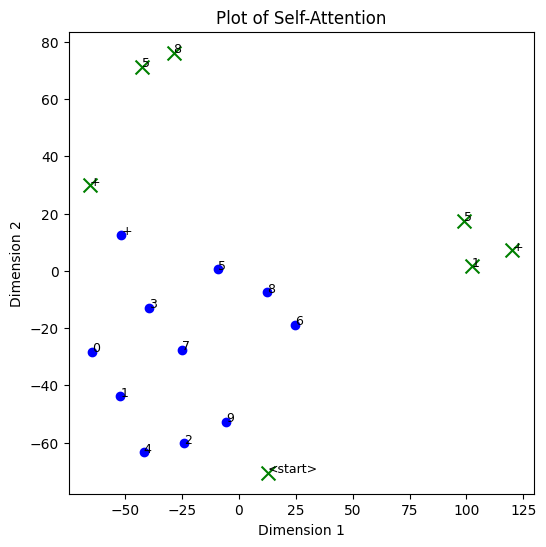

QV.shape: torch.Size([1, 7, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 7, 9])
AV.shape: torch.Size([1, 7, 16])
After Attention: tensor([[[  0.7486,  -0.0625,  -0.1263,  -0.0747,   2.6886,   3.9737,   0.6028,  -4.9474,   0.0735,
           -6.8973,   2.5990,  10.2992,  -3.0129,   0.3157,  -1.8084,  -1.7882]],

        [[  3.5969,  -0.6978,   0.2621,  -4.6506,  -6.5301,   7.7002,   5.6989,   0.5022,  -7.9907,
            1.4435,   1.2250,   3.3862,  -2.6924,   0.0175,  -1.2450,  -1.4005]],

        [[  4.9213,  -0.8815,   0.4878,  -6.0693,  -6.3636,  -1.1320,   4.3217,   4.4494, -10.7646,
            3.7112,   6.8345,   0.6620,   0.4126,  -1.4146,  -0.8852,   0.1755]],

        [[  2.4040,  -4.2600,   7.8516,  -7.4365,  -5.6696,   2.2525,   4.1732,   5.3516,  -4.6029,
            4.2193,   1.5493,  -0.6154,   3.8238,  -2.2647,  -1.9662,  -3.5307]],

        [[  2.0711,  -3.5523,   6.7265,  -8.3126,  -4.4077,   6.6339,   3.4312

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


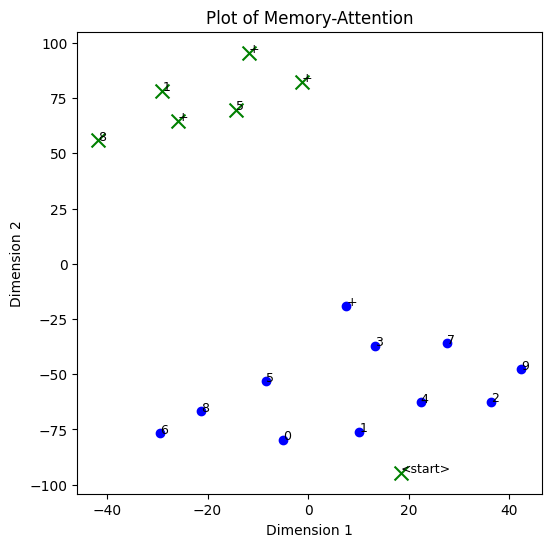

output.shape: torch.Size([1, 15])
output: tensor([[  0.9109,   2.0788,   0.7052,   0.7225,   0.8464,   1.7429,   1.1110,   1.4484,   0.4453,
           0.2056,  11.5483,  -5.0019, -35.3541, -10.6730, -10.8949]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 10

------------------

iter: 7
ys: tensor([[11],
        [ 1],
        [ 5],
        [10],
        [ 8],
        [ 5],
        [10],
        [10]], device='cuda:0')
tgt_embed: tensor([[[-0.7246,  2.9708, -2.1846,  2.4146, -2.8325,  0.6282, -1.4644, -0.4740, -1.6371, -0.3150,
          -2.4567,  2.2806,  2.9430, -0.6930, -0.4450, -0.4203]],

        [[ 0.5696, -0.1307,  1.2904,  1.7265,  1.1677,  1.3910,  1.0876, -0.2618,  1.4666, -1.6196,
          -0.4169,  3.7774, -1.0073,  2.5418, -1.7831,  0.3241]],

        [[ 0.0624, -1.7891,  1.2697, -0.3509, -0.7066,  2.6356,  2.4821,  1.0552, -0.2288,  0.3388,
          -2.8371, -0.0129, -0.9155,  2.0901, -2.9902, -0.6002]],

        [[ 0.5435, -2.1608,  1.1750, -0.5175,  0.258

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


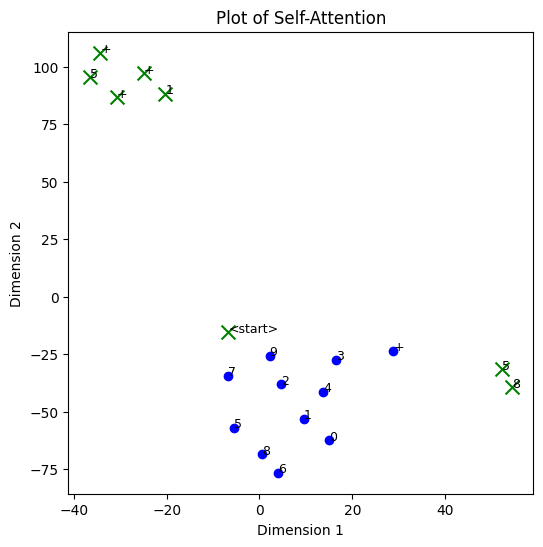

QV.shape: torch.Size([1, 8, 16])
KV.shape: torch.Size([1, 9, 16])
WV.shape: torch.Size([1, 9, 16])
attn_weight.shape: torch.Size([1, 8, 9])
AV.shape: torch.Size([1, 8, 16])
After Attention: tensor([[[  0.7611,  -0.0411,  -0.1257,  -0.0450,   2.6890,   3.9589,   0.5928,  -4.9423,   0.0653,
           -6.9024,   2.5870,  10.3039,  -3.0260,   0.3015,  -1.8077,  -1.7885]],

        [[  3.4113,  -0.7476,   0.4437,  -4.3908,  -6.4184,   8.1694,   5.7183,   0.2500,  -7.4800,
            1.0749,   0.6890,   3.5376,  -2.8030,   0.0821,  -1.2718,  -1.5786]],

        [[  4.8412,  -0.8204,   0.4461,  -5.8461,  -6.7742,   1.3023,   5.0390,   3.4672, -10.6554,
            2.8610,   5.7421,   1.7063,  -0.5307,  -1.1071,  -1.0524,  -0.2069]],

        [[  3.9237,  -2.6322,   4.9913,  -7.0012,  -6.9983,   1.2526,   4.7520,   5.3519,  -8.0329,
            4.5019,   3.4802,  -0.2151,   2.2359,  -2.1558,  -1.5602,  -2.0942]],

        [[  2.0594,  -3.5439,   6.7855,  -8.1509,  -4.5005,   6.7579,   3.4911

/tmp/ipykernel_258924/3717733127.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embed = apply_tsne(torch.cat((torch.tensor(embedded_weight), tgt_embed), dim=0), n_components=2)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


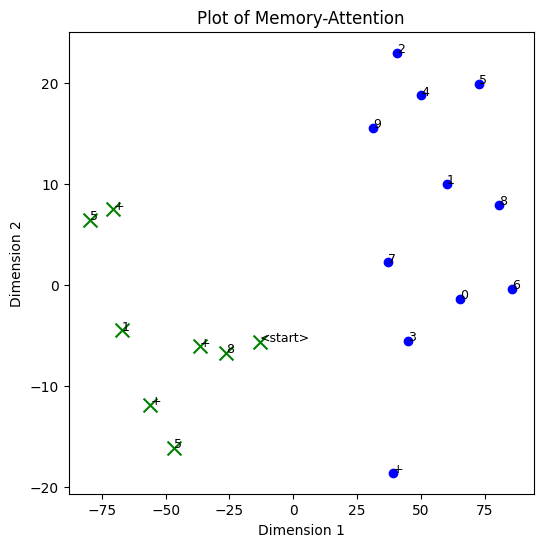

output.shape: torch.Size([1, 15])
output: tensor([[-12.5693,  -5.6521, -10.4536,  -8.3322,  -7.5729,   0.8850, -11.6564,  -9.5023,  -8.5385,
         -18.3990,  10.0677,  -0.7405,  27.2239,  -5.1709,  -1.3726]], device='cuda:0',
       grad_fn=<MmBackward0>)
predicted: 12

------------------

Input: ++15+85
Decoded sequence: 15+85++


In [144]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '++15+85'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d ,ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[:, :], title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    print(f"After Attention: {tgt}")
    # Memory-Attentionのベクトルの可視化
    # plot_embedding_tgt_2d(embedded_weight=embedded_num_2d, ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(embedded_weight=embedding_weight[:11, :], ys=ys, tgt_embed=tgt[:, :], src=src, title="Memory-Attention")

    # LayerNorm
    output = tgt.transpose(0, 1)[: ,-1]
    output = torch.matmul(output, embedding_weight.transpose(0, 1))

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

# Transformerの検算

スクラッチで書くための検算

## Multihead Attention

Multihead Attentionの動作をスクラッチで書きたいので、ここで検算する

参考サイト
https://blog.amedama.jp/entry/pytorch-multi-head-attention-verify

In [41]:
import torch
from torch import nn
import torch.nn.functional as F


In [42]:
edim = 4 # 埋め込み次元
num_heads = 1 # ヘッド数
model = nn.MultiheadAttention(edim, num_heads, bias=True, batch_first=True)

In [43]:
batch_size = 2
L=5
X = torch.randn(batch_size, L, edim) # 入力

Q = K = V = X # クエリ、キー、バリューは全て入力とする
print(Q.shape)
print(Q)

torch.Size([2, 5, 4])
tensor([[[ 0.7081,  1.2976, -0.4546,  0.4431],
         [-0.6822,  0.5295, -1.3371, -0.3064],
         [ 1.5062, -0.0801,  0.1847,  1.2997],
         [-2.4221,  1.0627, -1.6791,  0.9939],
         [-0.9887, -1.6506,  0.8445, -0.9542]],

        [[-0.5871, -1.7150, -0.0301, -0.3877],
         [-0.3579, -1.8666,  0.3904,  0.6014],
         [-0.5459, -0.2393, -0.9522,  0.5867],
         [-2.4177,  0.8151,  0.4212,  0.3914],
         [ 1.6865, -0.3065, -0.5988, -0.7868]]])


In [44]:

attn_output, attn_output_weights = model(Q, K, V)

print(attn_output.shape)
print(attn_output)



torch.Size([2, 5, 4])
tensor([[[ 1.7080e-01,  4.7807e-02,  6.1277e-03, -5.5004e-02],
         [ 1.5301e-01,  1.9499e-02,  3.8269e-02, -9.0058e-02],
         [ 1.5888e-01,  4.3968e-02,  1.2351e-04, -3.2740e-02],
         [ 2.4237e-01,  9.6631e-02,  1.2074e-02, -1.6315e-01],
         [ 1.3642e-01,  9.0575e-03,  2.8219e-02, -5.4507e-02]],

        [[ 2.0845e-02, -1.8673e-01,  1.1892e-01,  4.9382e-02],
         [ 2.8804e-02, -1.5712e-01,  9.5596e-02,  3.7563e-02],
         [ 2.4850e-02, -1.6325e-01,  8.5698e-02,  2.0576e-02],
         [ 2.5485e-02, -1.3964e-01,  2.8785e-02, -3.5115e-02],
         [ 1.4961e-02, -1.9467e-01,  1.6567e-01,  1.1701e-01]]], grad_fn=<TransposeBackward0>)


In [45]:
from pprint import pprint
pprint(list(model.named_parameters()))

[('in_proj_weight',
  Parameter containing:
tensor([[-0.0636, -0.1267, -0.1332, -0.5259],
        [ 0.1077,  0.5790,  0.1853,  0.1162],
        [-0.0904, -0.0464,  0.4076,  0.5243],
        [ 0.6122, -0.1540,  0.2078, -0.4861],
        [-0.1125,  0.2661, -0.2434,  0.0400],
        [-0.0259,  0.0518, -0.5276, -0.2583],
        [-0.1476,  0.3581, -0.5524, -0.2652],
        [ 0.0191, -0.6018, -0.3834, -0.3751],
        [ 0.1419, -0.5495, -0.2109,  0.2886],
        [ 0.1070, -0.2325, -0.5315,  0.5870],
        [-0.0335, -0.0104,  0.4285,  0.5688],
        [-0.3512, -0.3576,  0.6064, -0.3802]], requires_grad=True)),
 ('in_proj_bias',
  Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)),
 ('out_proj.weight',
  Parameter containing:
tensor([[-0.2426,  0.4921, -0.1437,  0.0276],
        [ 0.0213, -0.2659, -0.2625, -0.3208],
        [ 0.1609,  0.1301,  0.1104,  0.0733],
        [ 0.2079, -0.1287, -0.2260,  0.0667]], requires_grad=True)),
 ('out_p

In [46]:
model_weight = {name: param.data for name, param in model.named_parameters()}
Wi = model_weight['in_proj_weight']
Wo = model_weight['out_proj.weight']
Wbi = model_weight['in_proj_bias']
Wbo = model_weight['out_proj.bias']

In [47]:
Wi_q, Wi_k, Wi_v = Wi.chunk(3, dim=0)
Wbi_q, Wbi_k, Wbi_v = Wbi.chunk(3, dim=0)
QW = torch.matmul(Q, Wi_q.T) + Wbi_q
KW = torch.matmul(K, Wi_k.T) + Wbi_k
VW = torch.matmul(V, Wi_v.T) + Wbi_v

KW_t = KW.transpose(-2, -1)
QK_t = torch.bmm(QW, KW_t)
QK_scaled = QK_t / (edim ** 0.5)
attn_weights_ = F.softmax(QK_scaled, dim=-1)

In [48]:
print(attn_weights_)
print(attn_output_weights)

tensor([[[0.1948, 0.2310, 0.1740, 0.2075, 0.1928],
         [0.2323, 0.1364, 0.2942, 0.1670, 0.1701],
         [0.1712, 0.2596, 0.1411, 0.2062, 0.2219],
         [0.3624, 0.1015, 0.2634, 0.2280, 0.0447],
         [0.1926, 0.1686, 0.2291, 0.1859, 0.2237]],

        [[0.1911, 0.2447, 0.1743, 0.2362, 0.1536],
         [0.1733, 0.1926, 0.1929, 0.2697, 0.1714],
         [0.1460, 0.1891, 0.1889, 0.3169, 0.1592],
         [0.0792, 0.0913, 0.2083, 0.4794, 0.1417],
         [0.3083, 0.2965, 0.1384, 0.0728, 0.1841]]])
tensor([[[0.1948, 0.2310, 0.1740, 0.2075, 0.1928],
         [0.2323, 0.1364, 0.2942, 0.1670, 0.1701],
         [0.1712, 0.2596, 0.1411, 0.2062, 0.2219],
         [0.3624, 0.1015, 0.2634, 0.2280, 0.0447],
         [0.1926, 0.1686, 0.2291, 0.1859, 0.2237]],

        [[0.1911, 0.2447, 0.1743, 0.2362, 0.1536],
         [0.1733, 0.1926, 0.1929, 0.2697, 0.1714],
         [0.1460, 0.1891, 0.1889, 0.3169, 0.1592],
         [0.0792, 0.0913, 0.2083, 0.4794, 0.1417],
         [0.3083, 0.2965,

In [49]:
AV = torch.matmul(attn_weights_, VW)
attn_output_ = torch.matmul(AV, Wo.T) + Wbo

In [50]:
print(attn_output_)
print(attn_output)

tensor([[[ 1.7080e-01,  4.7807e-02,  6.1277e-03, -5.5004e-02],
         [ 1.5301e-01,  1.9499e-02,  3.8269e-02, -9.0058e-02],
         [ 1.5888e-01,  4.3968e-02,  1.2351e-04, -3.2740e-02],
         [ 2.4237e-01,  9.6631e-02,  1.2074e-02, -1.6315e-01],
         [ 1.3642e-01,  9.0575e-03,  2.8219e-02, -5.4507e-02]],

        [[ 2.0845e-02, -1.8673e-01,  1.1892e-01,  4.9382e-02],
         [ 2.8804e-02, -1.5712e-01,  9.5596e-02,  3.7563e-02],
         [ 2.4850e-02, -1.6325e-01,  8.5698e-02,  2.0576e-02],
         [ 2.5485e-02, -1.3964e-01,  2.8785e-02, -3.5115e-02],
         [ 1.4961e-02, -1.9467e-01,  1.6567e-01,  1.1701e-01]]])
tensor([[[ 1.7080e-01,  4.7807e-02,  6.1277e-03, -5.5004e-02],
         [ 1.5301e-01,  1.9499e-02,  3.8269e-02, -9.0058e-02],
         [ 1.5888e-01,  4.3968e-02,  1.2351e-04, -3.2740e-02],
         [ 2.4237e-01,  9.6631e-02,  1.2074e-02, -1.6315e-01],
         [ 1.3642e-01,  9.0575e-03,  2.8219e-02, -5.4507e-02]],

        [[ 2.0845e-02, -1.8673e-01,  1.1892e-01, 

## nn.Linear

In [51]:
model = nn.Linear(4, 4)
model

Linear(in_features=4, out_features=4, bias=True)

In [52]:
pprint(list(model.named_parameters()))

[('weight',
  Parameter containing:
tensor([[-0.3223,  0.0676, -0.3590,  0.2662],
        [-0.2742,  0.0158, -0.0894, -0.3773],
        [ 0.4112, -0.3346,  0.0349, -0.3703],
        [ 0.2947, -0.1641,  0.2244,  0.0344]], requires_grad=True)),
 ('bias',
  Parameter containing:
tensor([ 0.2672, -0.3914, -0.2502, -0.2255], requires_grad=True))]


In [53]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


torch.Size([4])
tensor([-0.9369, -0.6975, -0.0905,  0.2587])
torch.Size([4])
tensor([ 0.6233, -0.2350, -0.5010, -0.3985], grad_fn=<ViewBackward0>)


In [54]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

tensor([ 0.6233, -0.2350, -0.5010, -0.3985])
tensor([ 0.6233, -0.2350, -0.5010, -0.3985], grad_fn=<ViewBackward0>)


## nn.LayerNorm

参考サイト
https://qiita.com/dl_from_scratch/items/133fe741b67ed14f1856

In [55]:
model = nn.LayerNorm(4)
model

LayerNorm((4,), eps=1e-05, elementwise_affine=True)

In [56]:
pprint(list(model.named_parameters()))

[('weight', Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)),
 ('bias', Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True))]


In [57]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


torch.Size([4])
tensor([-1.3450, -0.3010,  0.2889,  1.2480])
torch.Size([4])
tensor([-1.4012, -0.2911,  0.3362,  1.3561], grad_fn=<NativeLayerNormBackward0>)


In [58]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

tensor([-0.1092, -0.1092, -0.1092, -0.1092])
tensor([-1.4012, -0.2911,  0.3362,  1.3561], grad_fn=<NativeLayerNormBackward0>)


/tmp/ipykernel_258924/3362812588.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  output_ = X.matmul(W.T) + B
